In [1]:
import numpy as np
import pandas as pd
import math
import random
from functools import reduce
import operator

import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import scatter_matrix
import seaborn as sns
import plotly.express as px
from pandas.plotting import parallel_coordinates

import scipy.stats as stats
from scipy.stats import yeojohnson

from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, auc as pr_auc, PrecisionRecallDisplay, roc_curve, roc_auc_score, f1_score, precision_score, recall_score, matthews_corrcoef

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import optuna

import shap 

import pymc as pm

c:\Users\user\anaconda3-64\envs\fraud-detection\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
df = pd.read_csv("dataset/fraud_detection_data.csv")

In [3]:
df.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
# No nulls to handle but dtype 'object' requires handling

In [6]:
df = df[:6000] # For computational ease to significantly reduce df size 

In [7]:
round(df["isFraud"].value_counts()/df.shape[0]*100,2) # Check that dataset reduction has maintained some the minority class

isFraud
0    99.13
1     0.87
Name: count, dtype: float64

In [8]:
obj_cols = df.select_dtypes(include="object")
df[obj_cols.columns] = obj_cols.astype("string")

In [9]:
df.describe()

step        amount  oldbalanceOrg  newbalanceOrig  \
count  6000.000000  6.000000e+03   6.000000e+03    6.000000e+03   
mean      2.492167  9.637212e+04   9.528965e+05    9.735261e+05   
std       1.731600  2.856691e+05   2.191924e+06    2.233441e+06   
min       1.000000  3.750000e+00   0.000000e+00    0.000000e+00   
25%       1.000000  3.723270e+03   4.902500e+02    0.000000e+00   
50%       2.000000  1.068460e+04   2.432829e+04    1.553563e+04   
75%       4.000000  9.910820e+04   2.159690e+05    2.249436e+05   
max       6.000000  1.000000e+07   1.293042e+07    1.301050e+07   

       oldbalanceDest  newbalanceDest      isFraud  isFlaggedFraud  
count    6.000000e+03    6.000000e+03  6000.000000          6000.0  
mean     9.028460e+05    1.044185e+06     0.008667             0.0  
std      2.562306e+06    2.919587e+06     0.092698             0.0  
min      0.000000e+00    0.000000e+00     0.000000             0.0  
25%      0.000000e+00    0.000000e+00     0.000000             0.0  
50%      0.000000e+00    0.000000e+00     0.000000             0.0  
75%      3.014023e+05    2.158513e+05     0.000000             0.0  
max      1.951612e+07    1.916920e+07     1.000000             0.0

In [10]:
df = df.drop("isFlaggedFraud", axis=1)

In [11]:
##########################

In [12]:
## Data Encoding

In [13]:
# For reference as encode:

df.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  
0  M1979787155             0.0             0.0        0  
1  M2044282225             0.0             0.0        0  
2   C553264065             0.0             0.0        1  
3    C38997010         21182.0             0.0        1  
4  M1230701703             0.0             0.0        0

In [14]:
df["type"].value_counts()

type
PAYMENT     3288
CASH_IN     1207
CASH_OUT     699
TRANSFER     517
DEBIT        289
Name: count, dtype: Int64

In [15]:
# No ordinality observed so to one-hot encode 'type' feature
df_encoded = pd.get_dummies(df, columns=["type"])

In [16]:
# Check 'nameOrig' to determine uniquness

df_encoded["nameOrig"].is_unique

True

In [17]:
# Check whether there's any 'nameOrig' entries that don't involve numbers prefixed with a 'C' followed by a number 
# between 1-9 (ensures that if 'C' is dropped then won't lose any leading zeroes as dtype int) and then the rest numbers

df_encoded[
    ~df_encoded["nameOrig"].str.contains("^C[1-9][0-9]*$", regex=True)
]  

Empty DataFrame
Columns: [step, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest, isFraud, type_CASH_IN, type_CASH_OUT, type_DEBIT, type_PAYMENT, type_TRANSFER]
Index: []

In [18]:
# Remove 'C' prefix

df_encoded["nameOrig"] = df_encoded["nameOrig"].str.replace("C", "").astype("int")

In [19]:
# As with 'nameOrig', check 'nameDest' for any entries not conforming to observed pattern and for any leading zeroes after letter

df_encoded[
    ~df_encoded["nameDest"].str.contains("^[MC][1-9][0-9]*$", regex=True)
]

Empty DataFrame
Columns: [step, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest, isFraud, type_CASH_IN, type_CASH_OUT, type_DEBIT, type_PAYMENT, type_TRANSFER]
Index: []

In [20]:
# Remove prefixes and one-hot encode information as no ordinality present

df_encoded["nameDestLabel"] = df_encoded["nameDest"].str[0]
df_encoded = pd.get_dummies(df_encoded, columns=["nameDestLabel"])
df_encoded["nameDest"] = df_encoded["nameDest"].str.replace("[MC]", "", regex=True).astype("int")

In [21]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   step             6000 non-null   int64  
 1   amount           6000 non-null   float64
 2   nameOrig         6000 non-null   int32  
 3   oldbalanceOrg    6000 non-null   float64
 4   newbalanceOrig   6000 non-null   float64
 5   nameDest         6000 non-null   int32  
 6   oldbalanceDest   6000 non-null   float64
 7   newbalanceDest   6000 non-null   float64
 8   isFraud          6000 non-null   int64  
 9   type_CASH_IN     6000 non-null   bool   
 10  type_CASH_OUT    6000 non-null   bool   
 11  type_DEBIT       6000 non-null   bool   
 12  type_PAYMENT     6000 non-null   bool   
 13  type_TRANSFER    6000 non-null   bool   
 14  nameDestLabel_C  6000 non-null   bool   
 15  nameDestLabel_M  6000 non-null   bool   
dtypes: bool(7), float64(5), int32(2), int64(2)
memory usage: 416

In [22]:
##########################

In [23]:
### EDA

In [24]:
## Univariate Analysis

In [25]:
# Select continuous variables
continuous_cols = df_encoded.select_dtypes(include=["int", "float"]).iloc[:,1:-1]


In [ ]:
# Run diagnostic plots to explore distributions and check for outliers

def diagnostic_plots(dataframe, variable):
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 3, 1)
    sns.histplot(dataframe[variable], bins=30, kde=True)
    plt.title(f"Histogram - {variable}")

    plt.subplot(1, 3, 2)
    stats.probplot(dataframe[variable], dist="norm", plot=plt)
    plt.ylabel("RM Quantiles")
    plt.title(f"Q-Q Plot - {variable}")

    plt.subplot(1, 3, 3)
    sns.boxplot(y=dataframe[variable])
    plt.title(f"Boxplot - {variable}")

    plt.show()

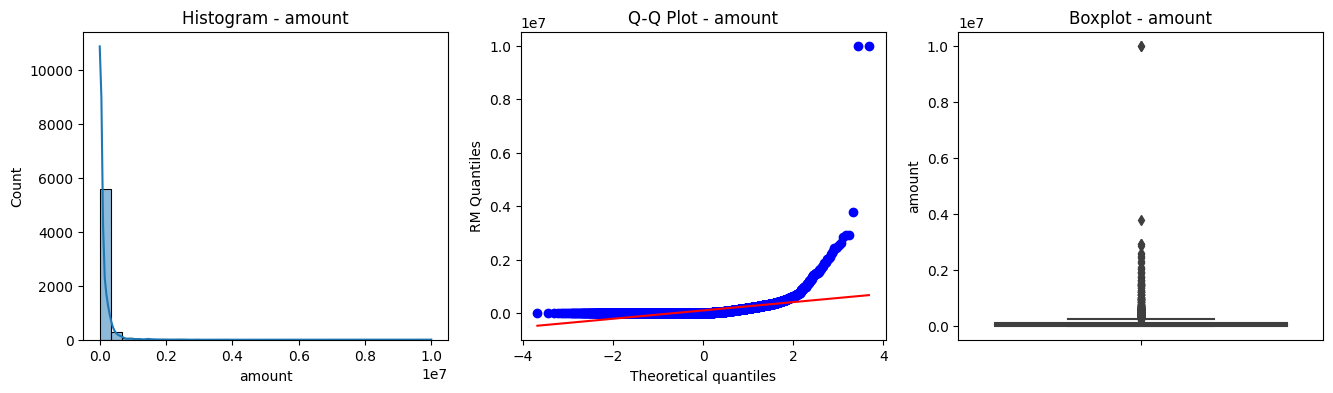

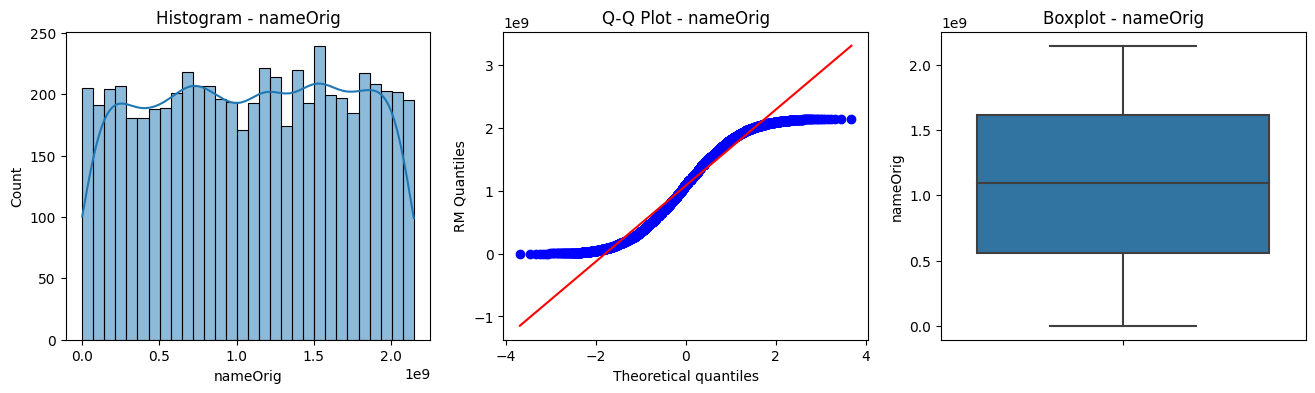

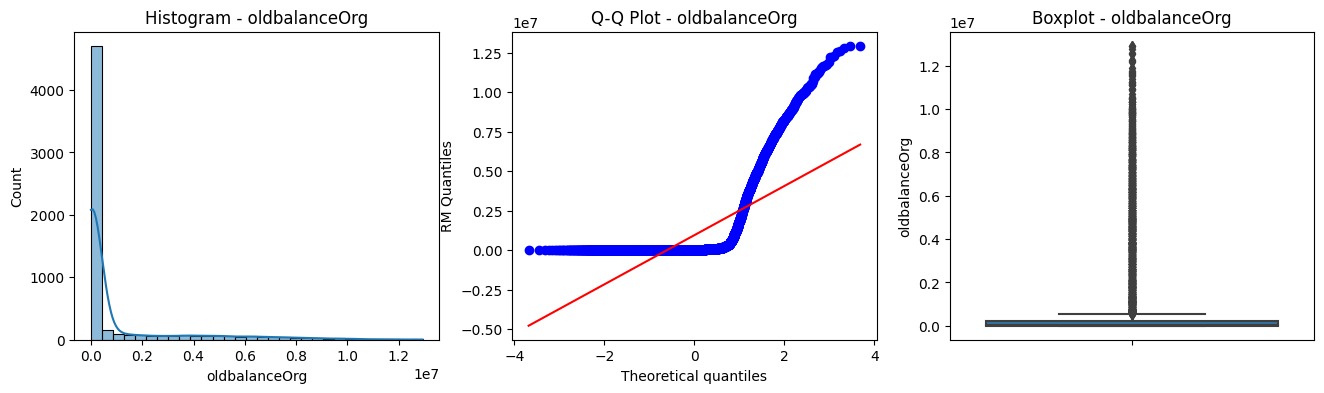

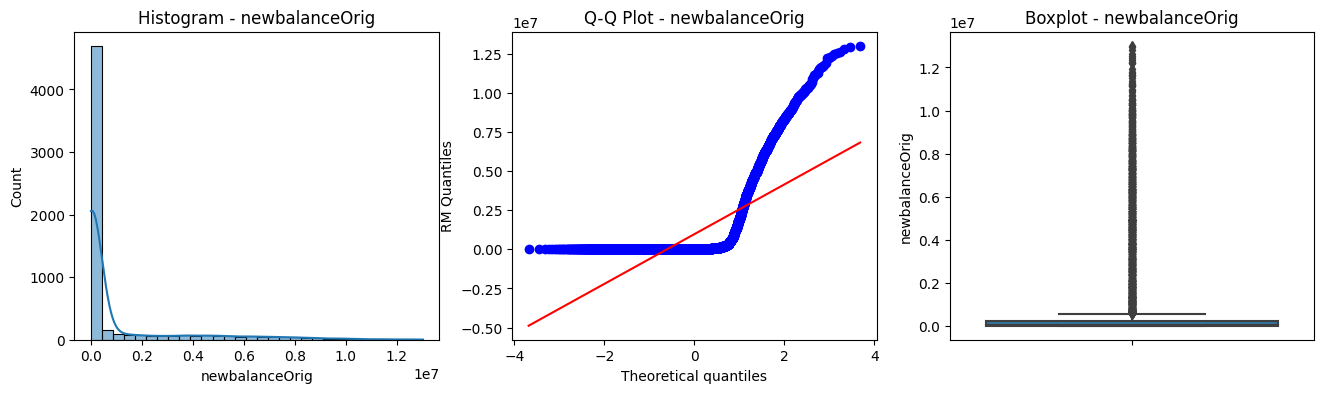

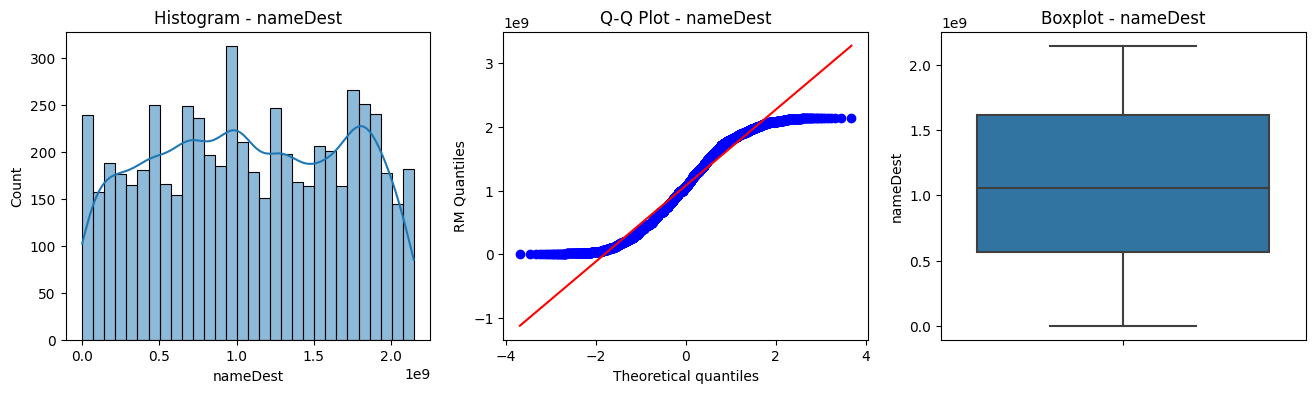

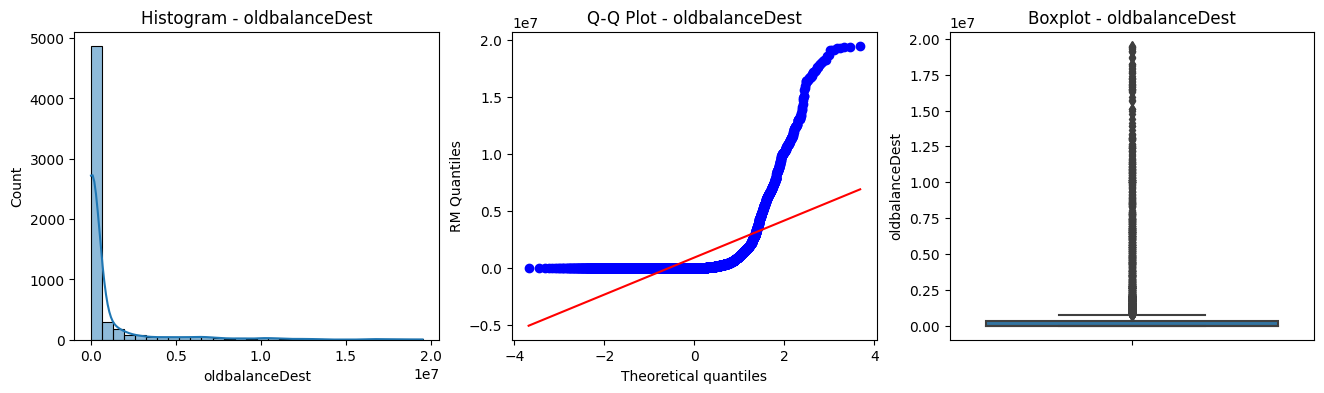

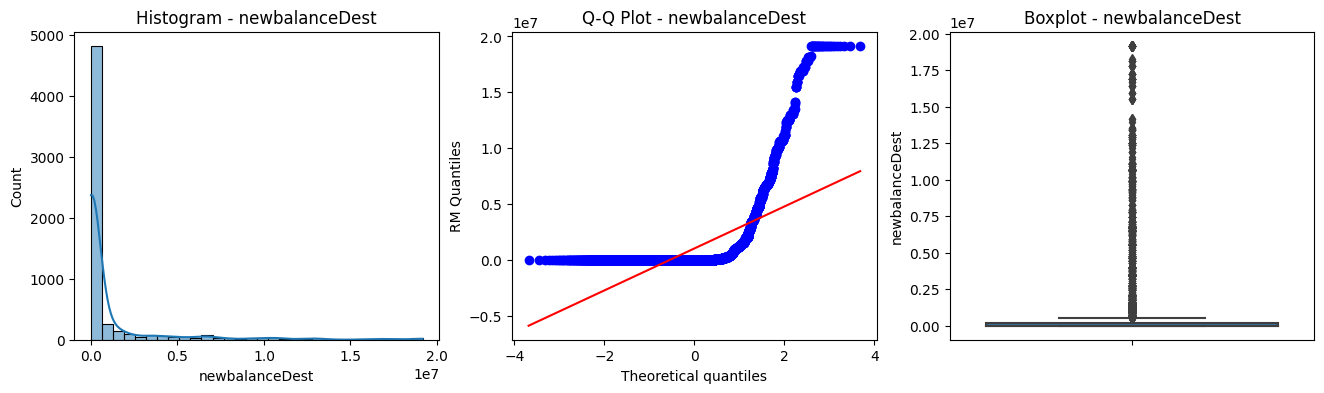

In [27]:
for col in continuous_cols.columns:
    diagnostic_plots(df_encoded, col)

In [28]:
# Extreme right skew shown for the continuous variables, bar 'nameDest'and 'nameOrig'.
# To attempt Yeo-Johnson transformation to address skew

In [26]:
skewed_cols = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]

transformed_df = df_encoded.copy()

for col in skewed_cols:
    transformed_df[col], _ = yeojohnson(transformed_df[col])

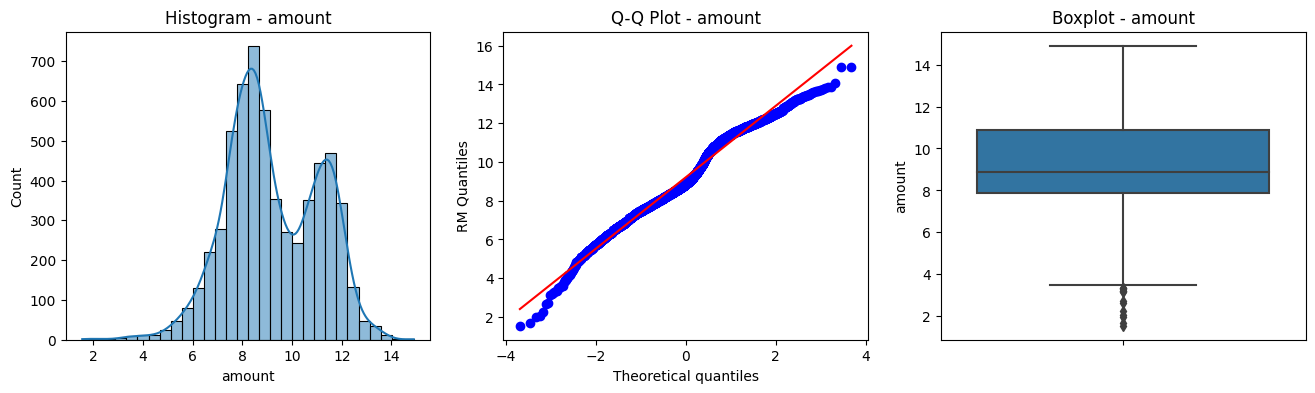

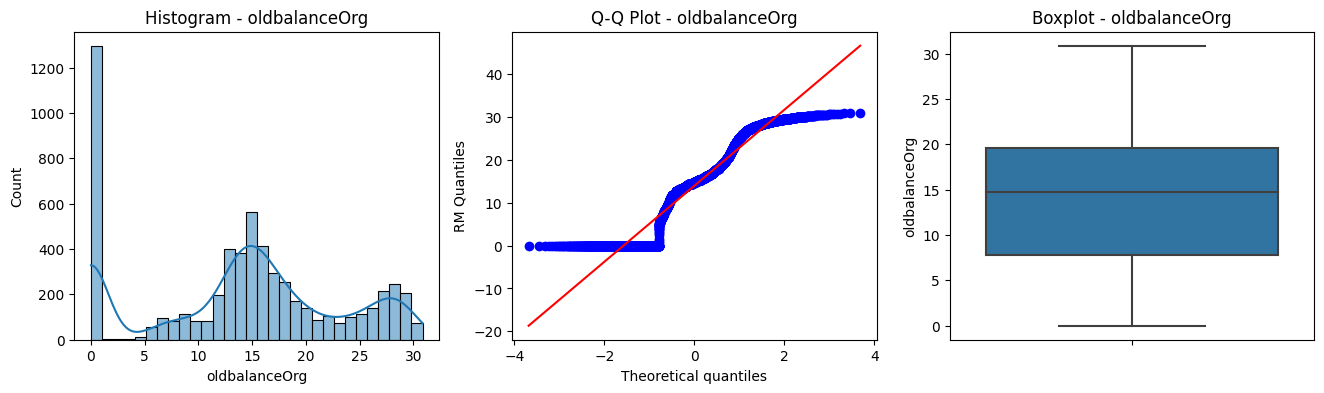

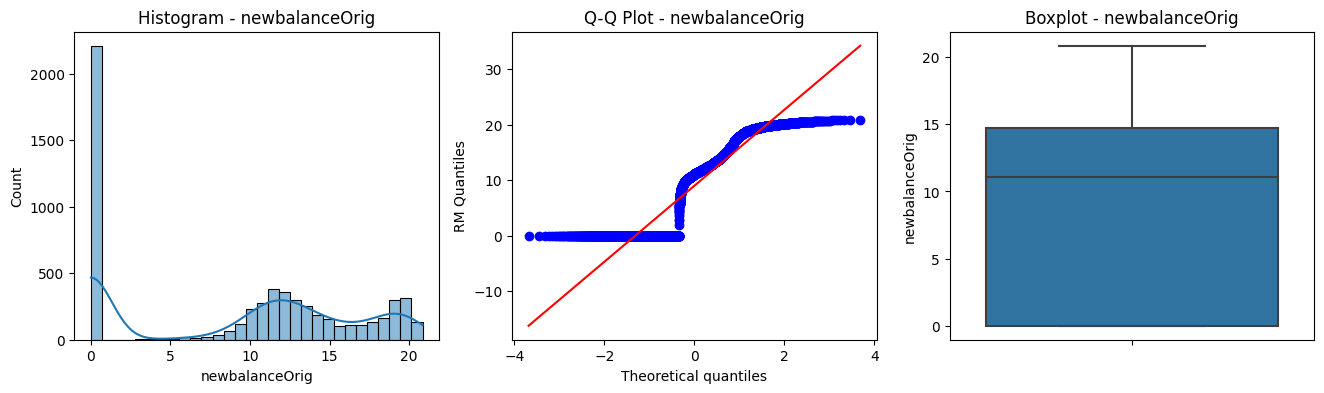

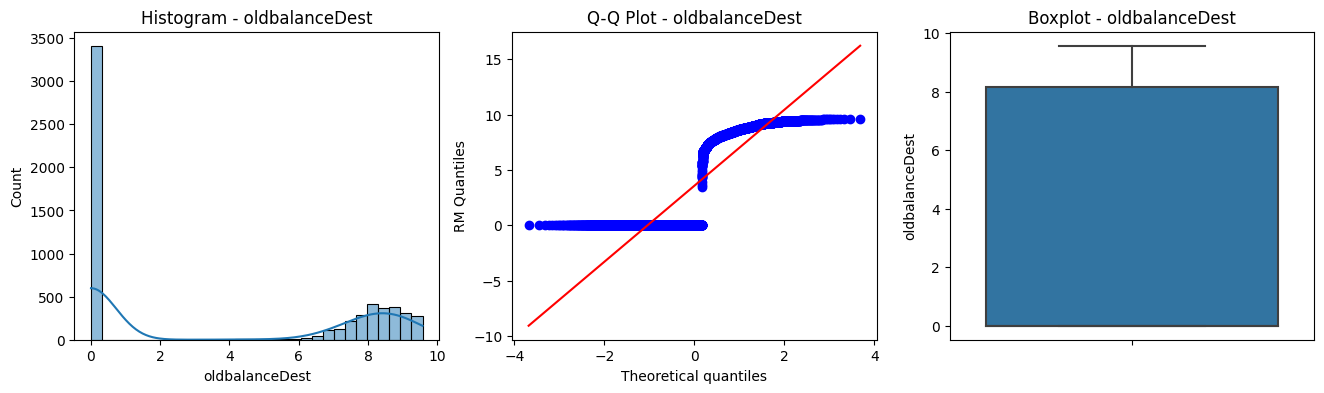

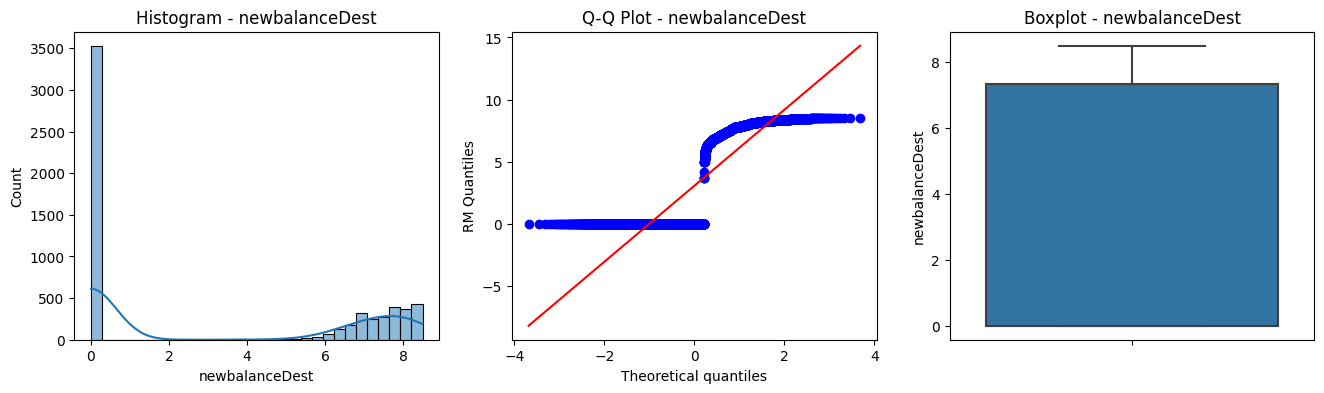

In [190]:
# Re-run diagnostics plots on selected columns:

for col in transformed_df[skewed_cols].columns:
    diagnostic_plots(transformed_df, col)

In [191]:
# Outliers largely handled.
# 'newbalanceOrig' and 'oldbalanceOrg' and, especially, 'amount' demonstrate clear biphasic natures, suggestive of multi-modal structure.
# Other variables problematic due to being zero-inflated, but still clear Gaussian-esque distributions after power transformation. 
# To investigate the possibility of sub-groupings/clusters in certain features after EDA completion with clustering algorithms.

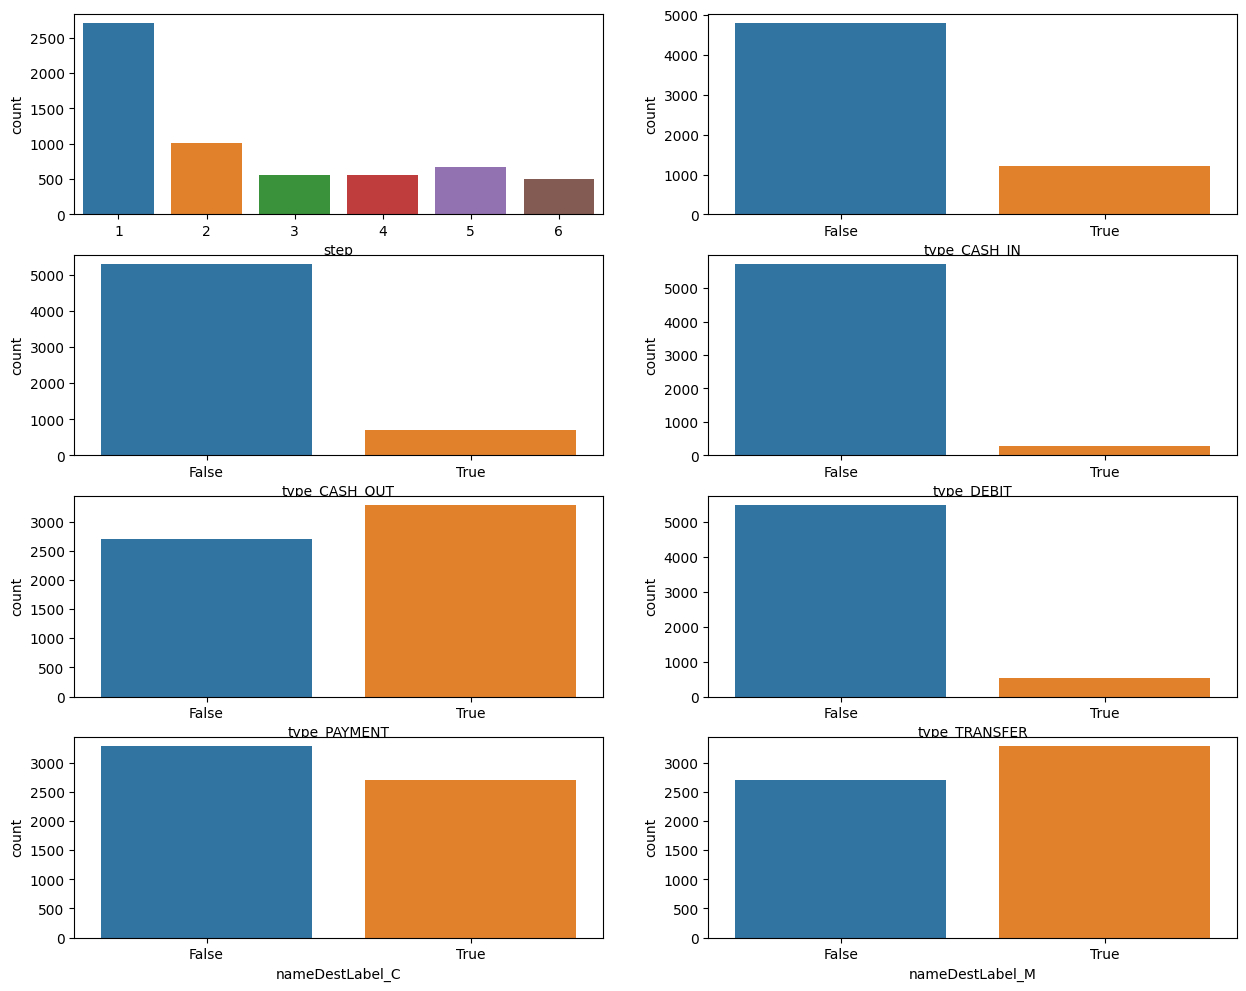

In [192]:
discrete_cols = pd.concat([transformed_df["step"], transformed_df.select_dtypes(include="bool")], axis=1).columns
n = len(discrete_cols)

fig, ax = plt.subplots(math.ceil(n/2), 2, figsize=(15,12), sharey=False)
axes = ax.flatten()

for i in range(n):
    sns.countplot(data=transformed_df, x=discrete_cols[i], ax=axes[i])


In [193]:
# Payment types: type_PAYMENT predominates dataset with a relatively harmonious balance between positive and negative instances, whilst cases of type_DEBIT are lowest. 
# Payment destination: Reasonably balanced amounts of customers and merchants.
# Step size: Inverse correlation with transaction length (in hours) and number of transactions.

In [194]:
## Bi-variate analysis

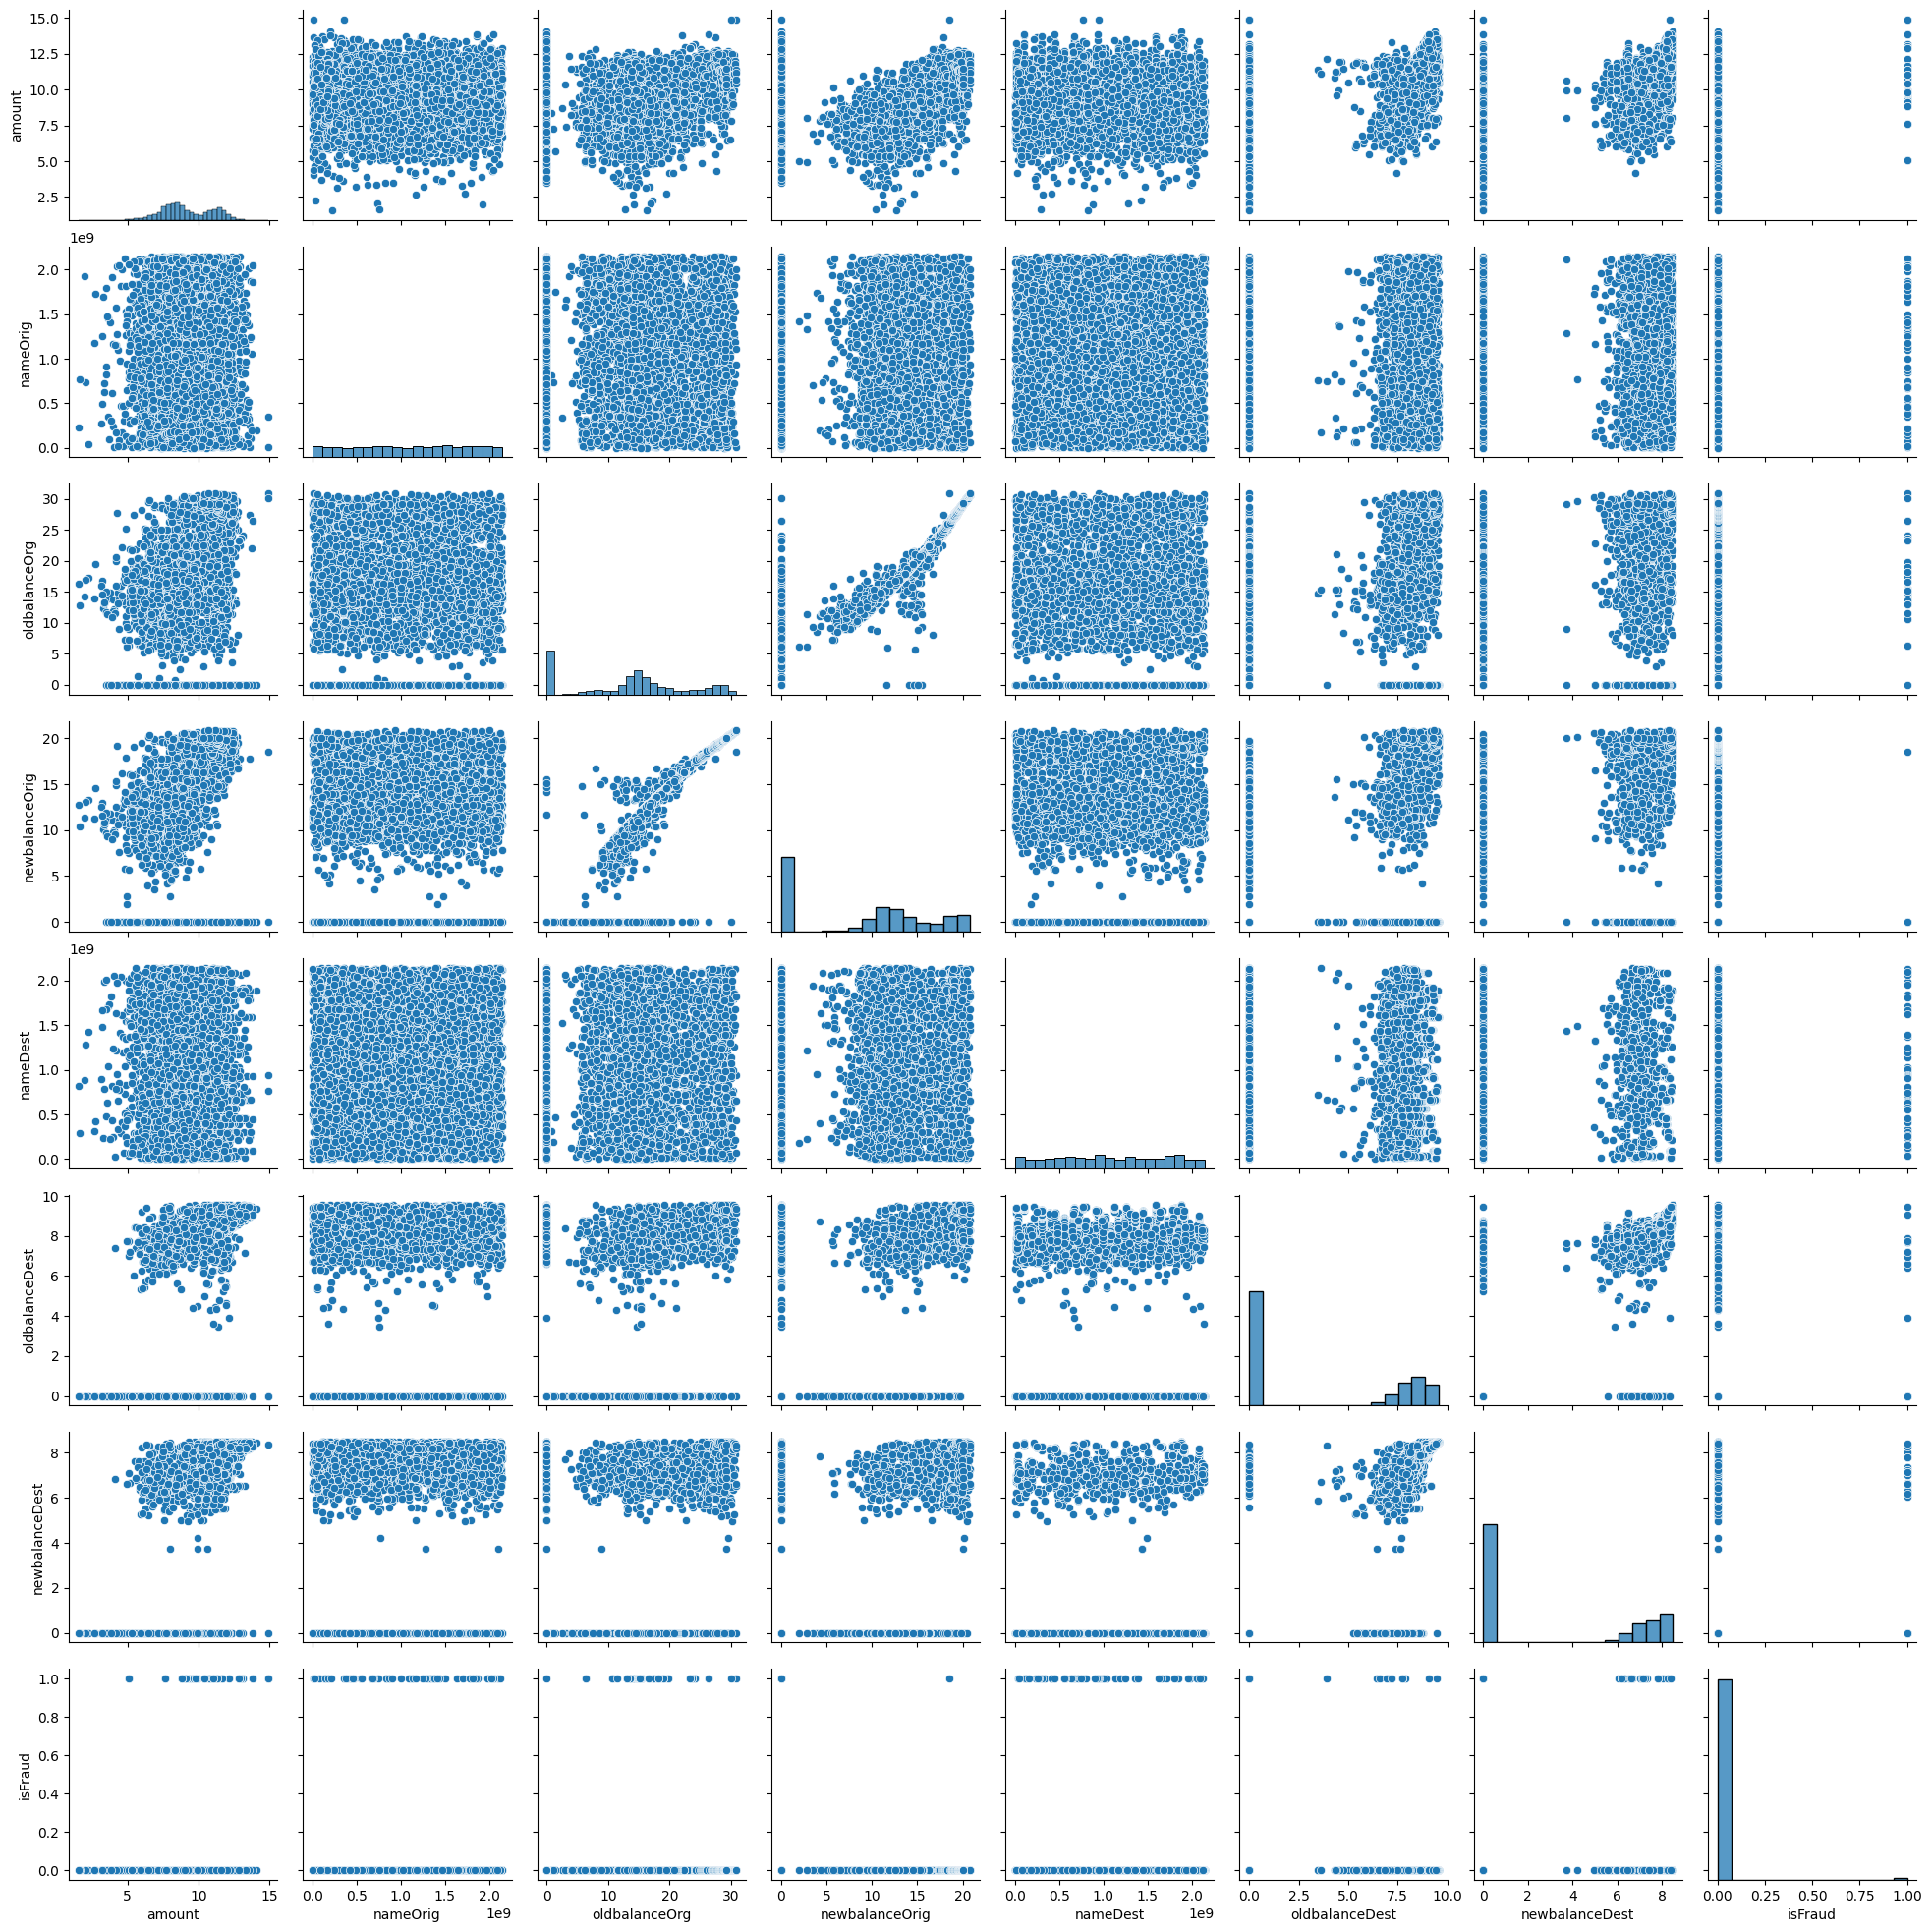

In [195]:
# Plot continuous features against one another and target

continuous_cols = transformed_df.select_dtypes(include=["int", "float"]).iloc[:,1:-1]

pair_plot_cols = pd.concat([continuous_cols, transformed_df["isFraud"]], axis=1)
sns.pairplot(pair_plot_cols)
plt.show()

In [196]:
# Linear relationships indicated between  old and new balance amounts.
# However, no strong discriminatory signals indicated with respect to the target for any range of values. 

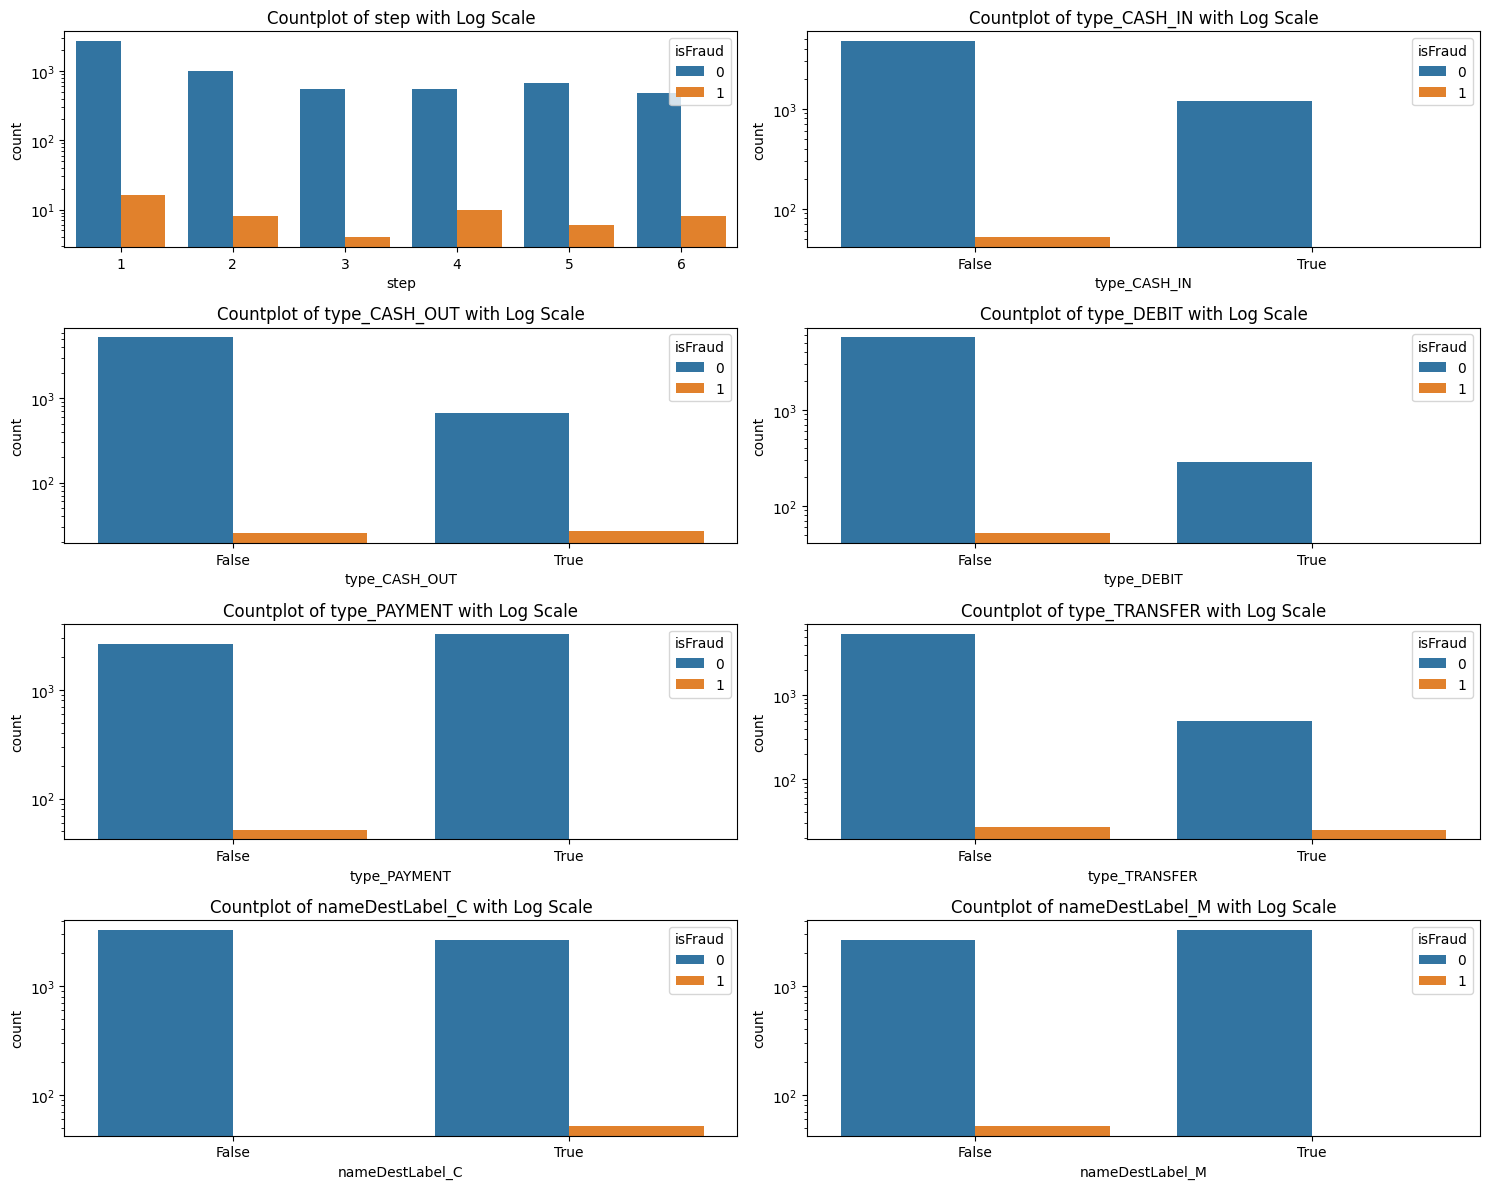

In [197]:
# Visualise relationship between discrete variables and target with log scaling to improve visualisation 
# where count amounts are comparatively very low

n = len(discrete_cols)

fig, ax = plt.subplots(math.ceil(n/2), 2, figsize=(15,12), sharey=False)
axes = ax.flatten()

for i in range(n):
    sns.countplot(data=transformed_df, x=discrete_cols[i], hue=transformed_df["isFraud"], ax=axes[i])    
    axes[i].set_yscale('log')
    axes[i].set_title(f'Countplot of {discrete_cols[i]} with Log Scale')     
    
plt.tight_layout()
plt.show()                 

In [198]:
# Positive instances of 'type_TRANSFER' and 'type_CASH_OUT' possess some occurrence of target as does the destination type being 'customer' and various lengths of transactions
# However, no discriminatory power revealed for features with respect to target yet.

In [199]:
# Underwhelming discriminatory power in bi-variate analysis may indicate nonlinearities 
# need to be explored along with attempts to feature engineer interactions terms.
# Analysis of subsequent modelling may prove insightful on this last point.   

In [200]:
## Multi-variate analysis

In [104]:
df_encoded.head()

step    amount    nameOrig  oldbalanceOrg  newbalanceOrig    nameDest  \
0     1   9839.64  1231006815       170136.0       160296.36  1979787155   
1     1   1864.28  1666544295        21249.0        19384.72  2044282225   
2     1    181.00  1305486145          181.0            0.00   553264065   
3     1    181.00   840083671          181.0            0.00    38997010   
4     1  11668.14  2048537720        41554.0        29885.86  1230701703   

   oldbalanceDest  newbalanceDest  isFraud  type_CASH_IN  type_CASH_OUT  \
0             0.0             0.0        0         False          False   
1             0.0             0.0        0         False          False   
2             0.0             0.0        1         False          False   
3         21182.0             0.0        1         False           True   
4             0.0             0.0        0         False          False   

   type_DEBIT  type_PAYMENT  type_TRANSFER  nameDestLabel_C  nameDestLabel_M  
0       False          True          False            False             True  
1       False          True          False            False             True  
2       False         False           True             True            False  
3       False         False          False             True            False  
4       False          True          False            False             True

In [142]:
# Parallel Coordinates Anlysis

pc_df = df_encoded.select_dtypes(include=["int", "float"]).iloc[:,:-1]
pc_df = pd.concat([pc_df, df_encoded[['type_CASH_OUT', 'type_TRANSFER', 'nameDestLabel_C','isFraud']]], axis=1)
pc_df.replace({True: 1, False: 0}, inplace=True)
pc_df = pc_df.drop('nameOrig', axis=1)

In [143]:
fig = px.parallel_coordinates(pc_df, color='isFraud')

fig.show()

In [ ]:
# When payments of type_CASH_OUT or type_TRANSFER and nameDestLable_C involve the lowest values of newbalanceOrig and a relatively high range of oldbalanceOrg full discrimination of some fraud cases possible.
# This highlights one pattern for payments of this type in which larger accounts are drained in a single transaction to a destination of type 'customer'.
# That said, the majority of fraud in dataset seem to occur at the lowest range of oldbalanceOrg and, here, the fraud cases can't be fully discriminated; however, they do again align themselves with type_CASH_OUT, type_TRANSFER and nameDestLabel_C.    

In [27]:
### Modelling and Tuning

In [27]:
X = transformed_df.drop("isFraud", axis=1)
y = transformed_df["isFraud"]

In [28]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)
scaled_X = pd.DataFrame(scaled_X, columns=X.columns)

In [29]:
random_seed = 42

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, stratify=y, random_state=random_seed # To stratify 'y' due to extreme class imbalance to ensure a proportional distribution of the target across splits
)

In [31]:
y_test.value_counts()

isFraud
0    1190
1      10
Name: count, dtype: int64

In [32]:
# SMOTE tuning

def objective(trial):
    sampling_strategy = trial.suggest_float("sampling_strategy", 0.1, 0.9)
    k_neighbors = trial.suggest_int("k_neighbors", 1, 10)

    smote = SMOTE(
        sampling_strategy=sampling_strategy,
        k_neighbors=k_neighbors,
        random_state=random_seed,
    )
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    models = (
        LogisticRegression(class_weight="balanced", max_iter=2000),
        DecisionTreeClassifier(random_state=random_seed),
        RandomForestClassifier(random_state=random_seed),
        XGBClassifier(),
        LGBMClassifier(),
        CatBoostClassifier(logging_level="Silent")
    )

    auc_pr_scores = []

    for model in models:
        model.fit(X_train_smote, y_train_smote)
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
        auc_pr_scores.append(
            pr_auc(recall, precision)
        )

    return max(auc_pr_scores)

# To use max precision-recall (PR) AUC metric as PR evaluates over varying thresholds unlike some other metrics.
# Also can send a good signal with respect to the minority class in severely imbalanced datasets.    

In [33]:
if __name__ == '__main__':
  study = optuna.create_study(direction="maximize")
  study.optimize(objective, n_trials=200)

  best_params = study.best_params

[I 2023-07-08 08:28:02,867] A new study created in memory with name: no-name-b890aa25-a0b3-4a5c-8101-a8b40f2654d3
[I 2023-07-08 08:28:12,002] Trial 0 finished with value: 0.9251794258373206 and parameters: {'sampling_strategy': 0.15748599776550876, 'k_neighbors': 5}. Best is trial 0 with value: 0.9251794258373206.
[I 2023-07-08 08:28:20,878] Trial 1 finished with value: 0.9060651629072681 and parameters: {'sampling_strategy': 0.5187106173412828, 'k_neighbors': 4}. Best is trial 0 with value: 0.9251794258373206.
[I 2023-07-08 08:28:30,353] Trial 2 finished with value: 0.9085714285714286 and parameters: {'sampling_strategy': 0.6010505328775919, 'k_neighbors': 2}. Best is trial 0 with value: 0.9251794258373206.
[I 2023-07-08 08:28:40,367] Trial 3 finished with value: 0.9049926686217009 and parameters: {'sampling_strategy': 0.7307578906807719, 'k_neighbors': 7}. Best is trial 0 with value: 0.9251794258373206.
[I 2023-07-08 08:28:49,074] Trial 4 finished with value: 0.9171604539251599 and p

In [34]:
sm = SMOTE(
    sampling_strategy=0.17163361203402655, k_neighbors=5, random_state=random_seed
)

X_smote, y_smote = sm.fit_resample(X_train, y_train)

Model:  Logistic Regression
Accuracy score: 0.99
Recall score: 0.9
Precision score: 0.45
F1 score: 0.6
Matthew's coeff: 0.6325230888370624
Precision-Recall: 0.8424410921698193


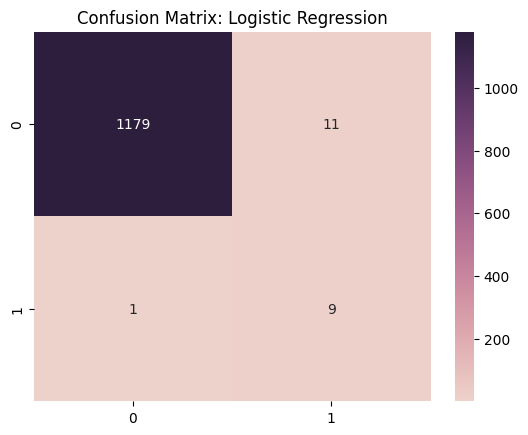

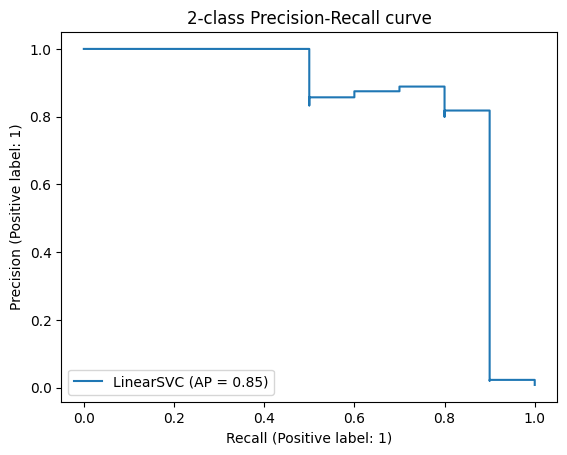

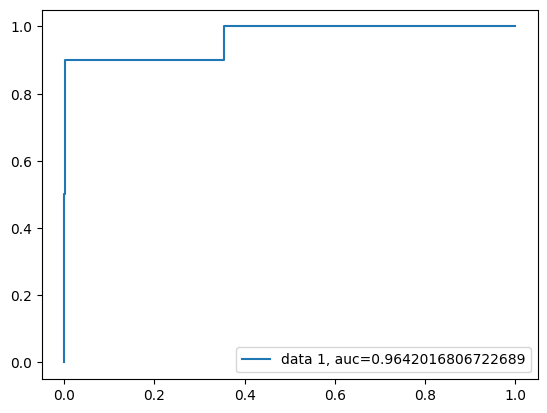

Model:  DecisionTreeClassifier
Accuracy score: 0.9966666666666667
Recall score: 0.9
Precision score: 0.75
F1 score: 0.8181818181818182
Matthew's coeff: 0.8199718226871268
Precision-Recall: 0.8254166666666667


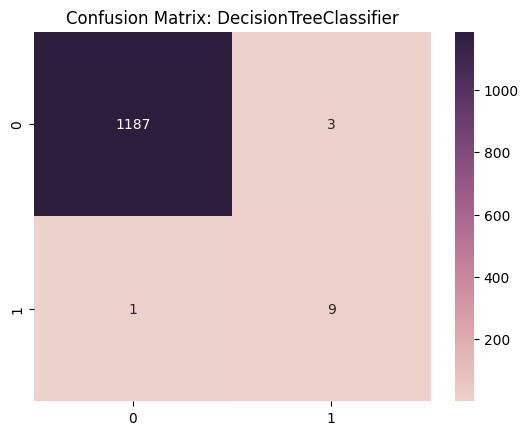

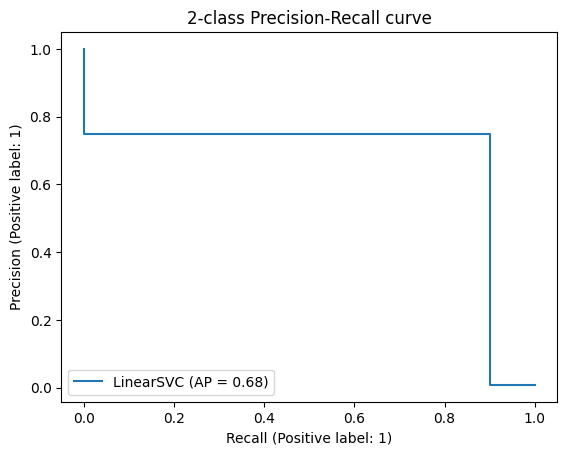

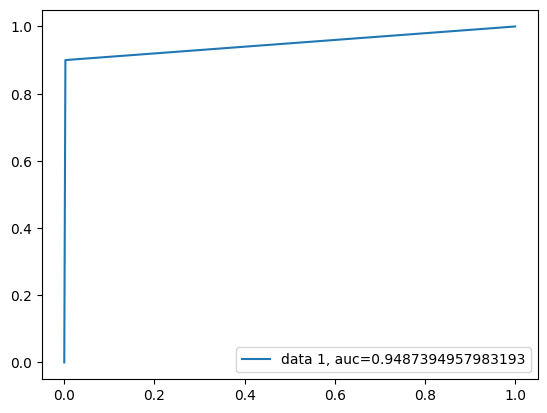

Model:  Support Vector Classifier
Accuracy score: 0.9933333333333333
Recall score: 0.9
Precision score: 0.5625
F1 score: 0.6923076923076923
Matthew's coeff: 0.708650837534925
Precision-Recall: 0.8699504123452498


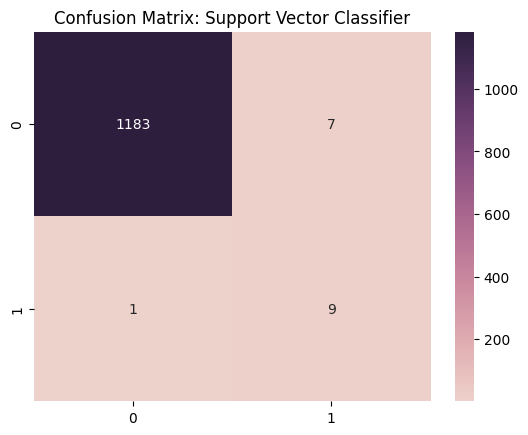

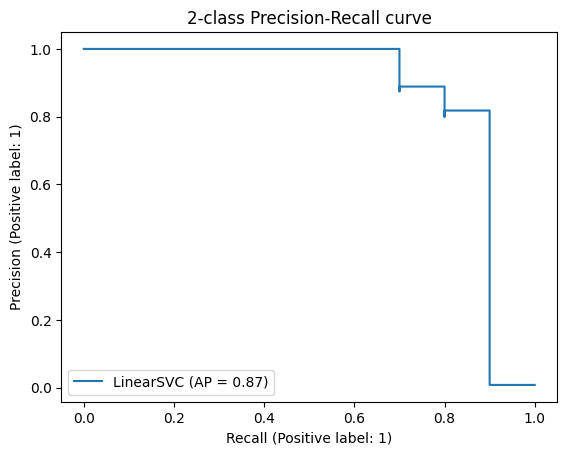

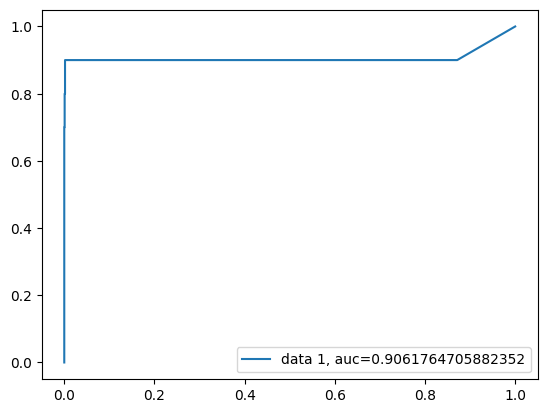

Model:  Random Forest
Accuracy score: 0.9975
Recall score: 0.8
Precision score: 0.8888888888888888
F1 score: 0.8421052631578948
Matthew's coeff: 0.842034528925021
Precision-Recall: 0.972020202020202


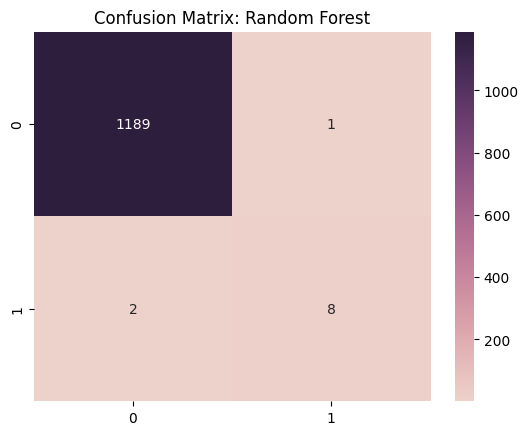

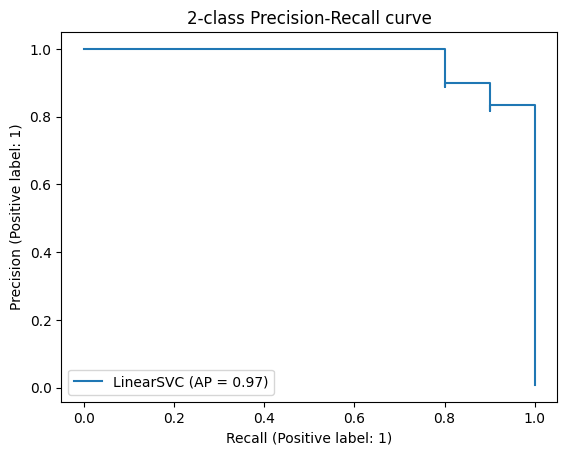

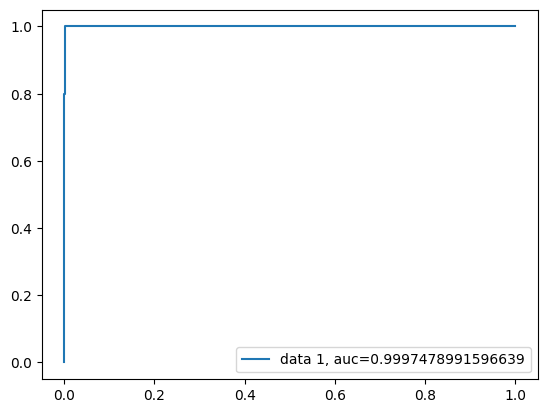

Model:  XGBoost
Accuracy score: 0.9966666666666667
Recall score: 0.8
Precision score: 0.8
F1 score: 0.8000000000000002
Matthew's coeff: 0.7983193277310925
Precision-Recall: 0.915413059163059


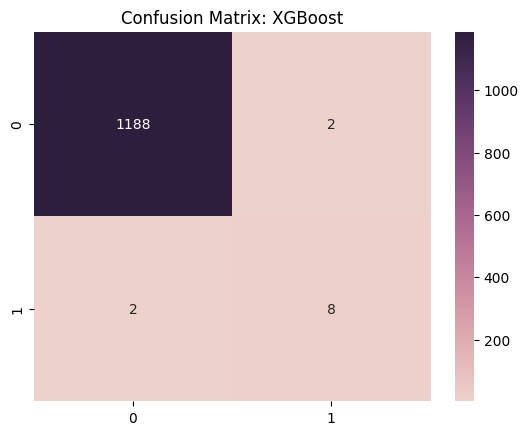

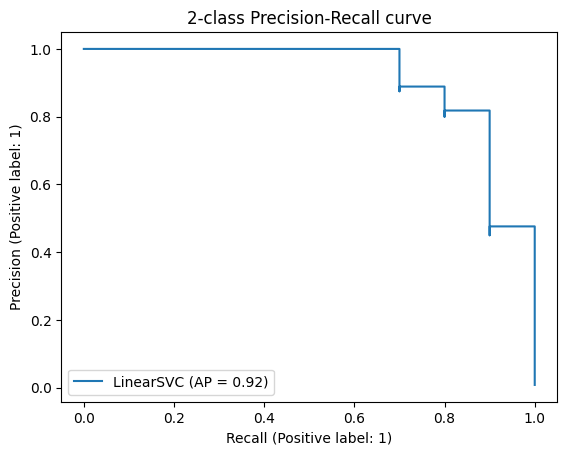

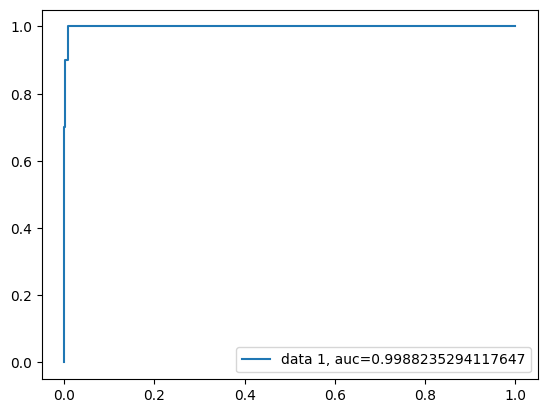

Model:  CatBoost
Accuracy score: 0.9966666666666667
Recall score: 0.8
Precision score: 0.8
F1 score: 0.8000000000000002
Matthew's coeff: 0.7983193277310925
Precision-Recall: 0.9201731601731602


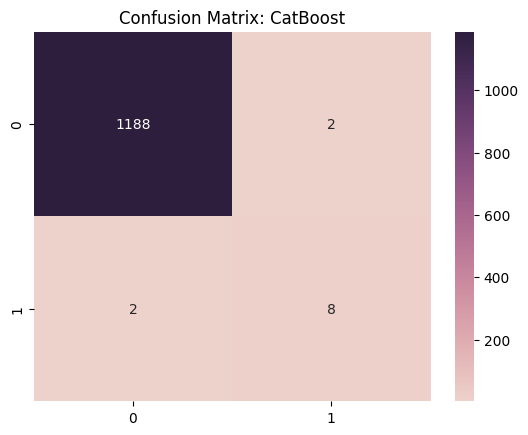

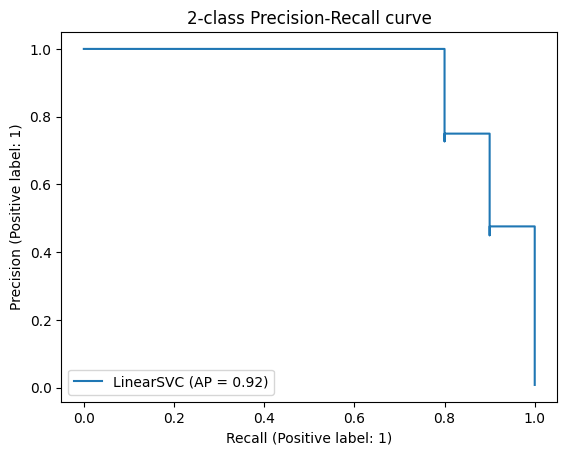

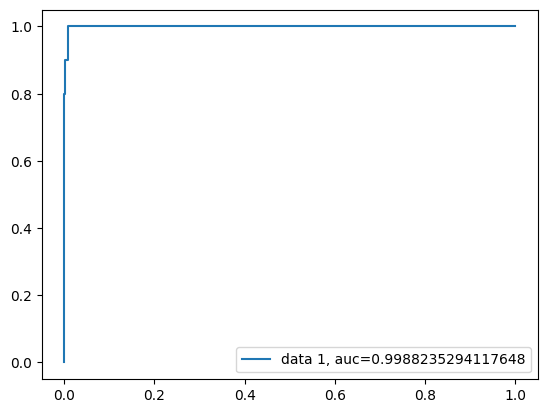

Model:  LightGBM
Accuracy score: 0.9966666666666667
Recall score: 0.8
Precision score: 0.8
F1 score: 0.8000000000000002
Matthew's coeff: 0.7983193277310925
Precision-Recall: 0.9083874458874458


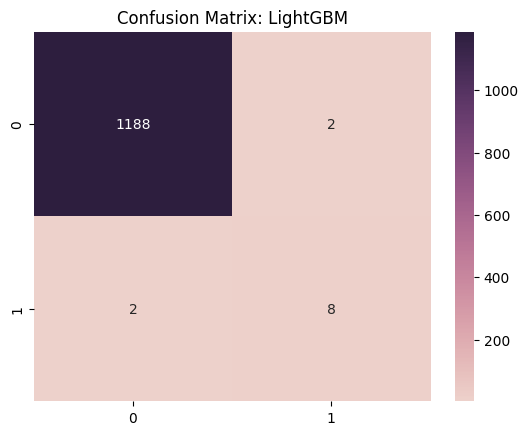

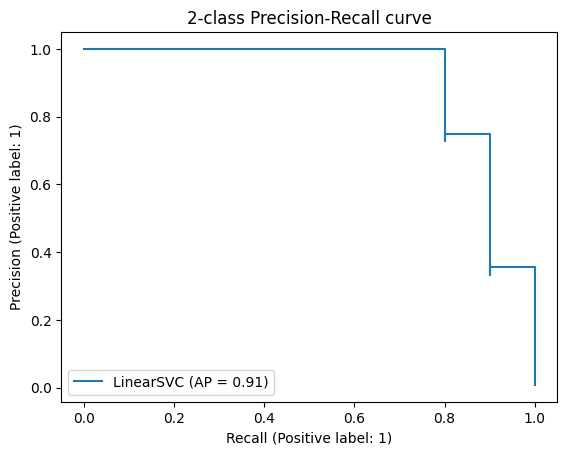

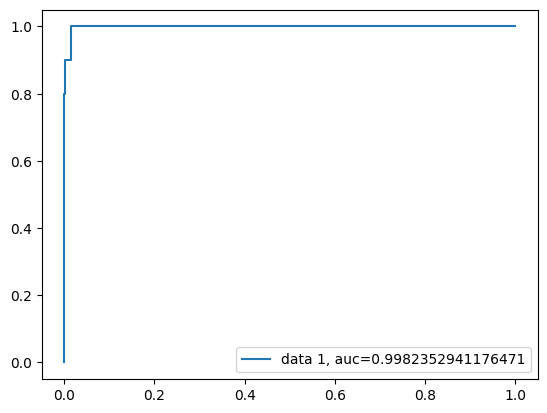

In [36]:
# To apply several models to data to get feel for performance
if __name__ == '__main__':
    models = {
        "Logistic Regression": LogisticRegression(class_weight="balanced", max_iter=2000),
        "DecisionTreeClassifier": DecisionTreeClassifier(random_state=random_seed),
        "Support Vector Classifier": SVC(probability=True),
        "Random Forest": RandomForestClassifier(random_state=random_seed),
        "XGBoost": XGBClassifier(),
        "CatBoost": CatBoostClassifier(logging_level="Silent"),
        "LightGBM": LGBMClassifier(),
    }

    for name, model in models.items():
        model.fit(X_smote, y_smote)
        y_pred = model.predict(X_test)

        print("Model: ", name)
        print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
        print(f"Recall score: {recall_score(y_test, y_pred)}")
        print(f"Precision score: {precision_score(y_test, y_pred)}")
        print(f"F1 score: {f1_score(y_test, y_pred)}")
        print(f"Matthew's coeff: {matthews_corrcoef(y_test, y_pred)}")
        y_pred_proba = model.predict_proba(X_test)[::, 1]
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
        print(f"Precision-Recall: {pr_auc(recall, precision)}")
        
        plt.figure()
        cf_matrix = confusion_matrix(y_test, y_pred)
        plt.title(f"Confusion Matrix: {name}")
        sns.heatmap(
            cf_matrix, annot=True, fmt="g", cmap=sns.cubehelix_palette(as_cmap=True)
        )
        plt.show()
        
        display = PrecisionRecallDisplay.from_estimator(
            model, X_test, y_test, name="LinearSVC"
        )
        _ = display.ax_.set_title("2-class Precision-Recall curve")
        plt.show()
        
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc2 = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label="data 1, auc=" + str(auc2))
        plt.legend(loc=4)
        plt.show()

In [ ]:
## Logistic Regression: 
# High recall but low precision - indicating high false positives 
# and, thus, an over-eager algorithm in terms of classifying positive cases of fraud.
# Undesirable algorithmic imbalance in caution and eagerness, especially given use case.

## SVC: 
# Good precision but relatively low recall suggesting an overly conservative approach
# Decent PR score indicates relatively consistent performance. 

## Decision Tree:
# Perfectly balanced precision and recall but PR score much lower suggesting model not as performant over threshold range.

## Ensemble Models:
# Significantly more performant than other models given strong scoring and much more harmonious metrics in general.
# Interestingly, Random Forest more performant currently than boosting algorithms.

# High initial performance of models reinforces suspicion of nonlinearities and the need for feature engineering interaction terms to tease such relationships out.   
# To proceed with model hyperparameter tuning to see if any further improvements can be made. 

In [264]:
# Hyerparameter Tuning

def objective(trial):
    model_type = trial.suggest_categorical(
        "model_type", ["random_forest", "xgboost", "lgbm", "catboost"]
    )

    if model_type == "random_forest":
        max_depth = trial.suggest_int("max_depth", 5, X_smote.shape[1])
        max_features = trial.suggest_int("max_features", 1, 5)
        n_estimators = trial.suggest_int("n_estimators", 1, 20)
        criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
        model = RandomForestClassifier(
            max_depth=max_depth,
            max_features=max_features,
            n_estimators=n_estimators,
            criterion=criterion,
        )

    if model_type == "xgboost":
        max_depth = trial.suggest_int("max_depth", 1, 50)
        learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
        n_estimators = trial.suggest_int("n_estimators", 1, 100)
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.01, 1)
        model = XGBClassifier(
            max_depth=max_depth,
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            colsample_bytree=colsample_bytree,
        )

    if model_type == "lgbm":
        num_leaves = trial.suggest_int("num_leaves",  2, 50)
        min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 1, 500)
        max_depth = trial.suggest_int("max_depth", 1, 500)
        learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
        model = LGBMClassifier(
            num_leaves=num_leaves,
            min_data_in_leaf=min_data_in_leaf,
            max_depth=max_depth,
            learning_rate=learning_rate,
        )

    if model_type == "catboost":
        learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
        max_depth = trial.suggest_int("max_depth", 1, 16)
        n_estimators = trial.suggest_int("n_estimators", 1, 1000)
        model = CatBoostClassifier(
            learning_rate=learning_rate,
            max_depth=max_depth,
            n_estimators=n_estimators,
            logging_level="Silent",
        )

    if trial.should_prune():
        raise optuna.TrialPruned()

    model.fit(X_smote, y_smote)
    y_pred_proba = model.predict_proba(X_test)[::, 1]
    precision, recall,_ = precision_recall_curve(y_test, y_pred_proba)
    score = pr_auc(recall, precision)
    return score

In [265]:
if __name__ == '__main__':
    study = optuna.create_study(
        direction='maximize',
        sampler= optuna.samplers.TPESampler()
    )
    study.optimize(objective, n_trials=100)

    print(f'Number of finished trials: {len(study.trials)}')

    print(f'Best trial:')
    trial = study.best_trial

    print(f'Value: {trial.value}')

    print('Params: ')
    for key, value in trial.params.items():
        print(f'    {key}: {value}')

[I 2023-06-30 13:48:45,271] A new study created in memory with name: no-name-bf11a3ba-87fb-4248-9056-dcdaa08d0937
[I 2023-06-30 13:48:45,292] Trial 0 finished with value: 0.569546783625731 and parameters: {'model_type': 'random_forest', 'max_depth': 13, 'max_features': 4, 'n_estimators': 1, 'criterion': 'gini'}. Best is trial 0 with value: 0.569546783625731.
[I 2023-06-30 13:55:32,483] Trial 1 finished with value: 0.8596722896986054 and parameters: {'model_type': 'catboost', 'learning_rate': 0.4695689345545121, 'max_depth': 14, 'n_estimators': 877}. Best is trial 1 with value: 0.8596722896986054.
[I 2023-06-30 13:55:32,595] Trial 2 finished with value: 0.865485514381191 and parameters: {'model_type': 'xgboost', 'max_depth': 35, 'learning_rate': 0.20966541485053738, 'n_estimators': 35, 'colsample_bytree': 0.5026262739561941}. Best is trial 2 with value: 0.865485514381191.
[I 2023-06-30 13:55:32,677] Trial 3 finished with value: 0.8269493362298291 and parameters: {'model_type': 'xgboost'

[LightGBM] [Warning] min_data_in_leaf is set=485, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=485


[I 2023-06-30 13:58:52,989] Trial 5 finished with value: 0.9000927643784787 and parameters: {'model_type': 'catboost', 'learning_rate': 0.252473158921644, 'max_depth': 14, 'n_estimators': 441}. Best is trial 4 with value: 0.9069226044226043.
[I 2023-06-30 13:58:53,066] Trial 6 finished with value: 0.755562726424821 and parameters: {'model_type': 'xgboost', 'max_depth': 10, 'learning_rate': 0.9042049826250979, 'n_estimators': 62, 'colsample_bytree': 0.38061962505106367}. Best is trial 4 with value: 0.9069226044226043.
[I 2023-06-30 13:58:53,131] Trial 7 finished with value: 0.7997693947512459 and parameters: {'model_type': 'random_forest', 'max_depth': 5, 'max_features': 3, 'n_estimators': 12, 'criterion': 'gini'}. Best is trial 4 with value: 0.9069226044226043.
[I 2023-06-30 13:58:53,202] Trial 8 finished with value: 0.8789497810618501 and parameters: {'model_type': 'xgboost', 'max_depth': 31, 'learning_rate': 0.2448636111406867, 'n_estimators': 28, 'colsample_bytree': 0.79275421995148

[LightGBM] [Warning] min_data_in_leaf is set=457, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=457
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


[I 2023-06-30 13:58:53,503] Trial 12 finished with value: 0.9247313797313798 and parameters: {'model_type': 'lgbm', 'num_leaves': 20, 'min_data_in_leaf': 90, 'max_depth': 233, 'learning_rate': 0.5167480256806949}. Best is trial 12 with value: 0.9247313797313798.
[I 2023-06-30 13:58:53,600] Trial 13 finished with value: 0.9092513368983958 and parameters: {'model_type': 'lgbm', 'num_leaves': 11, 'min_data_in_leaf': 29, 'max_depth': 327, 'learning_rate': 0.42843449757401325}. Best is trial 12 with value: 0.9247313797313798.


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=162, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=162


[I 2023-06-30 13:58:53,678] Trial 14 finished with value: 0.9078535353535354 and parameters: {'model_type': 'lgbm', 'num_leaves': 10, 'min_data_in_leaf': 162, 'max_depth': 362, 'learning_rate': 0.407270874662307}. Best is trial 12 with value: 0.9247313797313798.
[I 2023-06-30 13:58:53,762] Trial 15 finished with value: 0.8895244419215279 and parameters: {'model_type': 'lgbm', 'num_leaves': 13, 'min_data_in_leaf': 146, 'max_depth': 334, 'learning_rate': 0.05927974015551618}. Best is trial 12 with value: 0.9247313797313798.
[I 2023-06-30 13:58:53,842] Trial 16 finished with value: 0.8978626928626928 and parameters: {'model_type': 'lgbm', 'num_leaves': 20, 'min_data_in_leaf': 111, 'max_depth': 139, 'learning_rate': 0.43119759729849816}. Best is trial 12 with value: 0.9247313797313798.


[LightGBM] [Warning] min_data_in_leaf is set=146, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=146
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] min_data_in_leaf is set=322, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=322


[I 2023-06-30 13:58:53,902] Trial 17 finished with value: 0.5041666666666667 and parameters: {'model_type': 'lgbm', 'num_leaves': 3, 'min_data_in_leaf': 322, 'max_depth': 355, 'learning_rate': 0.7973407441377593}. Best is trial 12 with value: 0.9247313797313798.
[I 2023-06-30 13:58:55,920] Trial 18 finished with value: 0.8512638353709783 and parameters: {'model_type': 'catboost', 'learning_rate': 0.5086951932672281, 'max_depth': 1, 'n_estimators': 943}. Best is trial 12 with value: 0.9247313797313798.
[I 2023-06-30 13:58:55,954] Trial 19 finished with value: 0.5326973684210526 and parameters: {'model_type': 'random_forest', 'max_depth': 15, 'max_features': 1, 'n_estimators': 1, 'criterion': 'entropy'}. Best is trial 12 with value: 0.9247313797313798.
[I 2023-06-30 13:58:56,026] Trial 20 finished with value: 0.9211868686868687 and parameters: {'model_type': 'lgbm', 'num_leaves': 24, 'min_data_in_leaf': 276, 'max_depth': 299, 'learning_rate': 0.9548048097644728}. Best is trial 12 with va

[LightGBM] [Warning] min_data_in_leaf is set=276, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=276
[LightGBM] [Warning] min_data_in_leaf is set=286, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=286
[LightGBM] [Warning] min_data_in_leaf is set=222, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=222


[I 2023-06-30 13:58:56,171] Trial 22 finished with value: 0.9423737373737374 and parameters: {'model_type': 'lgbm', 'num_leaves': 17, 'min_data_in_leaf': 222, 'max_depth': 430, 'learning_rate': 0.7831060881670152}. Best is trial 22 with value: 0.9423737373737374.
[I 2023-06-30 13:58:56,248] Trial 23 finished with value: 0.8950793650793651 and parameters: {'model_type': 'lgbm', 'num_leaves': 22, 'min_data_in_leaf': 214, 'max_depth': 411, 'learning_rate': 0.8366215456125925}. Best is trial 22 with value: 0.9423737373737374.
[I 2023-06-30 13:58:56,323] Trial 24 finished with value: 0.903018207282913 and parameters: {'model_type': 'lgbm', 'num_leaves': 28, 'min_data_in_leaf': 357, 'max_depth': 165, 'learning_rate': 0.9856456651618766}. Best is trial 22 with value: 0.9423737373737374.


[LightGBM] [Warning] min_data_in_leaf is set=214, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=214
[LightGBM] [Warning] min_data_in_leaf is set=357, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=357
[LightGBM] [Warning] min_data_in_leaf is set=224, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=224


[I 2023-06-30 13:58:56,399] Trial 25 finished with value: 0.9316722166722166 and parameters: {'model_type': 'lgbm', 'num_leaves': 17, 'min_data_in_leaf': 224, 'max_depth': 418, 'learning_rate': 0.749014897761923}. Best is trial 22 with value: 0.9423737373737374.
[I 2023-06-30 13:58:56,475] Trial 26 finished with value: 0.9228102453102452 and parameters: {'model_type': 'lgbm', 'num_leaves': 17, 'min_data_in_leaf': 207, 'max_depth': 443, 'learning_rate': 0.7336974706440345}. Best is trial 22 with value: 0.9423737373737374.


[LightGBM] [Warning] min_data_in_leaf is set=207, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=207


[I 2023-06-30 14:20:56,833] Trial 27 finished with value: 0.8142605068554435 and parameters: {'model_type': 'catboost', 'learning_rate': 0.6883533506300732, 'max_depth': 16, 'n_estimators': 654}. Best is trial 22 with value: 0.9423737373737374.
[I 2023-06-30 14:20:56,959] Trial 28 finished with value: 0.8753756157635468 and parameters: {'model_type': 'random_forest', 'max_depth': 15, 'max_features': 5, 'n_estimators': 5, 'criterion': 'entropy'}. Best is trial 22 with value: 0.9423737373737374.
[I 2023-06-30 14:20:57,039] Trial 29 finished with value: 0.9121428571428571 and parameters: {'model_type': 'random_forest', 'max_depth': 15, 'max_features': 1, 'n_estimators': 8, 'criterion': 'gini'}. Best is trial 22 with value: 0.9423737373737374.
[I 2023-06-30 14:20:57,178] Trial 30 finished with value: 0.8238961385836385 and parameters: {'model_type': 'lgbm', 'num_leaves': 29, 'min_data_in_leaf': 110, 'max_depth': 406, 'learning_rate': 0.8086134406482429}. Best is trial 22 with value: 0.9423

[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] min_data_in_leaf is set=218, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=218


[I 2023-06-30 14:20:57,310] Trial 31 finished with value: 0.8829252691752691 and parameters: {'model_type': 'lgbm', 'num_leaves': 17, 'min_data_in_leaf': 218, 'max_depth': 491, 'learning_rate': 0.7878277216640459}. Best is trial 22 with value: 0.9423737373737374.
[I 2023-06-30 14:20:57,429] Trial 32 finished with value: 0.9381286549707603 and parameters: {'model_type': 'lgbm', 'num_leaves': 15, 'min_data_in_leaf': 207, 'max_depth': 440, 'learning_rate': 0.7333846268820624}. Best is trial 22 with value: 0.9423737373737374.
[I 2023-06-30 14:20:57,551] Trial 33 finished with value: 0.924626762126762 and parameters: {'model_type': 'lgbm', 'num_leaves': 49, 'min_data_in_leaf': 180, 'max_depth': 456, 'learning_rate': 0.8831244728163933}. Best is trial 22 with value: 0.9423737373737374.


[LightGBM] [Warning] min_data_in_leaf is set=207, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=207
[LightGBM] [Warning] min_data_in_leaf is set=180, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=180
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84


[I 2023-06-30 14:20:57,994] Trial 34 finished with value: 0.9167353017353017 and parameters: {'model_type': 'lgbm', 'num_leaves': 6, 'min_data_in_leaf': 84, 'max_depth': 401, 'learning_rate': 0.7373008163117694}. Best is trial 22 with value: 0.9423737373737374.
[I 2023-06-30 14:20:58,152] Trial 35 finished with value: 0.5890877462622572 and parameters: {'model_type': 'xgboost', 'max_depth': 50, 'learning_rate': 0.6543901458394098, 'n_estimators': 62, 'colsample_bytree': 0.0978648837695546}. Best is trial 22 with value: 0.9423737373737374.
[I 2023-06-30 14:32:14,324] Trial 36 finished with value: 0.773239879224549 and parameters: {'model_type': 'catboost', 'learning_rate': 0.8677556537250112, 'max_depth': 16, 'n_estimators': 341}. Best is trial 22 with value: 0.9423737373737374.
[I 2023-06-30 14:32:14,412] Trial 37 finished with value: 0.9266403000594178 and parameters: {'model_type': 'lgbm', 'num_leaves': 16, 'min_data_in_leaf': 254, 'max_depth': 266, 'learning_rate': 0.742161041497781

[LightGBM] [Warning] min_data_in_leaf is set=254, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=254
[LightGBM] [Warning] min_data_in_leaf is set=255, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=255


[I 2023-06-30 14:32:14,583] Trial 39 finished with value: 0.8828936542847833 and parameters: {'model_type': 'lgbm', 'num_leaves': 15, 'min_data_in_leaf': 255, 'max_depth': 449, 'learning_rate': 0.8298333293756719}. Best is trial 22 with value: 0.9423737373737374.
[I 2023-06-30 14:40:08,390] Trial 40 finished with value: 0.7966177262704304 and parameters: {'model_type': 'catboost', 'learning_rate': 0.6772858699324099, 'max_depth': 16, 'n_estimators': 238}. Best is trial 22 with value: 0.9423737373737374.
[I 2023-06-30 14:40:08,491] Trial 41 finished with value: 0.9384458556149733 and parameters: {'model_type': 'lgbm', 'num_leaves': 19, 'min_data_in_leaf': 329, 'max_depth': 267, 'learning_rate': 0.6289976457343899}. Best is trial 22 with value: 0.9423737373737374.
[I 2023-06-30 14:40:08,585] Trial 42 finished with value: 0.8635029447676507 and parameters: {'model_type': 'lgbm', 'num_leaves': 9, 'min_data_in_leaf': 372, 'max_depth': 273, 'learning_rate': 0.7489977700194365}. Best is trial

[LightGBM] [Warning] min_data_in_leaf is set=329, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=329
[LightGBM] [Warning] min_data_in_leaf is set=372, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=372
[LightGBM] [Warning] min_data_in_leaf is set=306, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=306


[I 2023-06-30 14:40:08,706] Trial 43 finished with value: 0.905718954248366 and parameters: {'model_type': 'lgbm', 'num_leaves': 17, 'min_data_in_leaf': 306, 'max_depth': 389, 'learning_rate': 0.6261641744642492}. Best is trial 22 with value: 0.9423737373737374.
[I 2023-06-30 14:40:08,812] Trial 44 finished with value: 0.8327542505803375 and parameters: {'model_type': 'lgbm', 'num_leaves': 14, 'min_data_in_leaf': 246, 'max_depth': 203, 'learning_rate': 0.6982065581597771}. Best is trial 22 with value: 0.9423737373737374.
[I 2023-06-30 14:40:08,903] Trial 45 finished with value: 0.9142582417582418 and parameters: {'model_type': 'lgbm', 'num_leaves': 20, 'min_data_in_leaf': 340, 'max_depth': 381, 'learning_rate': 0.7637612695353453}. Best is trial 22 with value: 0.9423737373737374.


[LightGBM] [Warning] min_data_in_leaf is set=246, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=246
[LightGBM] [Warning] min_data_in_leaf is set=340, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=340


[I 2023-06-30 14:40:09,062] Trial 46 finished with value: 0.8704970760233918 and parameters: {'model_type': 'xgboost', 'max_depth': 39, 'learning_rate': 0.6289151228213457, 'n_estimators': 72, 'colsample_bytree': 0.6961567319232913}. Best is trial 22 with value: 0.9423737373737374.
[I 2023-06-30 14:40:09,160] Trial 47 finished with value: 0.8978626928626928 and parameters: {'model_type': 'lgbm', 'num_leaves': 7, 'min_data_in_leaf': 420, 'max_depth': 473, 'learning_rate': 0.9070208374905089}. Best is trial 22 with value: 0.9423737373737374.
[I 2023-06-30 14:40:09,227] Trial 48 finished with value: 0.9461038961038961 and parameters: {'model_type': 'random_forest', 'max_depth': 15, 'max_features': 3, 'n_estimators': 4, 'criterion': 'entropy'}. Best is trial 48 with value: 0.9461038961038961.
[I 2023-06-30 14:40:09,293] Trial 49 finished with value: 0.8585735171261487 and parameters: {'model_type': 'random_forest', 'max_depth': 9, 'max_features': 3, 'n_estimators': 5, 'criterion': 'entropy

[LightGBM] [Warning] min_data_in_leaf is set=420, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=420


[I 2023-06-30 14:40:09,357] Trial 50 finished with value: 0.4224226187529305 and parameters: {'model_type': 'random_forest', 'max_depth': 5, 'max_features': 2, 'n_estimators': 4, 'criterion': 'entropy'}. Best is trial 48 with value: 0.9461038961038961.
[I 2023-06-30 14:40:09,478] Trial 51 finished with value: 0.8645827783327784 and parameters: {'model_type': 'random_forest', 'max_depth': 12, 'max_features': 5, 'n_estimators': 9, 'criterion': 'entropy'}. Best is trial 48 with value: 0.9461038961038961.
[I 2023-06-30 14:40:09,576] Trial 52 finished with value: 0.8485306905370844 and parameters: {'model_type': 'random_forest', 'max_depth': 7, 'max_features': 2, 'n_estimators': 12, 'criterion': 'entropy'}. Best is trial 48 with value: 0.9461038961038961.
[I 2023-06-30 14:40:09,666] Trial 53 finished with value: 0.9100198412698411 and parameters: {'model_type': 'lgbm', 'num_leaves': 13, 'min_data_in_leaf': 247, 'max_depth': 83, 'learning_rate': 0.7068576630350601}. Best is trial 48 with val

[LightGBM] [Warning] min_data_in_leaf is set=247, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=247
[LightGBM] [Warning] min_data_in_leaf is set=195, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=195


[I 2023-06-30 14:40:09,820] Trial 55 finished with value: 0.8115277777777778 and parameters: {'model_type': 'random_forest', 'max_depth': 11, 'max_features': 4, 'n_estimators': 3, 'criterion': 'gini'}. Best is trial 54 with value: 0.9512387612387612.
[I 2023-06-30 14:40:09,929] Trial 56 finished with value: 0.9450650738150738 and parameters: {'model_type': 'lgbm', 'num_leaves': 22, 'min_data_in_leaf': 191, 'max_depth': 423, 'learning_rate': 0.5723174681505632}. Best is trial 54 with value: 0.9512387612387612.
[I 2023-06-30 14:40:10,036] Trial 57 finished with value: 0.8819769119769119 and parameters: {'model_type': 'lgbm', 'num_leaves': 32, 'min_data_in_leaf': 184, 'max_depth': 341, 'learning_rate': 0.5753008011356545}. Best is trial 54 with value: 0.9512387612387612.


[LightGBM] [Warning] min_data_in_leaf is set=191, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=191
[LightGBM] [Warning] min_data_in_leaf is set=184, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=184
[LightGBM] [Warning] min_data_in_leaf is set=131, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=131


[I 2023-06-30 14:40:10,162] Trial 58 finished with value: 0.9463852813852814 and parameters: {'model_type': 'lgbm', 'num_leaves': 23, 'min_data_in_leaf': 131, 'max_depth': 430, 'learning_rate': 0.5255713534792417}. Best is trial 54 with value: 0.9512387612387612.
[I 2023-06-30 14:40:10,261] Trial 59 finished with value: 0.6737858807448153 and parameters: {'model_type': 'xgboost', 'max_depth': 22, 'learning_rate': 0.5427963895167819, 'n_estimators': 23, 'colsample_bytree': 0.33460490896978223}. Best is trial 54 with value: 0.9512387612387612.
[I 2023-06-30 14:59:01,178] Trial 60 finished with value: 0.8557353614630061 and parameters: {'model_type': 'catboost', 'learning_rate': 0.4628913671874368, 'max_depth': 16, 'n_estimators': 629}. Best is trial 54 with value: 0.9512387612387612.
[I 2023-06-30 14:59:01,303] Trial 61 finished with value: 0.9345757020757022 and parameters: {'model_type': 'lgbm', 'num_leaves': 22, 'min_data_in_leaf': 138, 'max_depth': 428, 'learning_rate': 0.54092569190

[LightGBM] [Warning] min_data_in_leaf is set=138, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=138
[LightGBM] [Warning] min_data_in_leaf is set=193, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=193


[I 2023-06-30 14:59:01,491] Trial 63 finished with value: 0.9161960261960261 and parameters: {'model_type': 'lgbm', 'num_leaves': 27, 'min_data_in_leaf': 152, 'max_depth': 471, 'learning_rate': 0.6527743809190797}. Best is trial 54 with value: 0.9512387612387612.
[I 2023-06-30 14:59:01,584] Trial 64 finished with value: 0.9044769119769119 and parameters: {'model_type': 'lgbm', 'num_leaves': 19, 'min_data_in_leaf': 165, 'max_depth': 500, 'learning_rate': 0.4878457146758647}. Best is trial 54 with value: 0.9512387612387612.


[LightGBM] [Warning] min_data_in_leaf is set=152, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=152
[LightGBM] [Warning] min_data_in_leaf is set=165, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=165
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130


[I 2023-06-30 14:59:01,678] Trial 65 finished with value: 0.9187626262626262 and parameters: {'model_type': 'lgbm', 'num_leaves': 24, 'min_data_in_leaf': 130, 'max_depth': 366, 'learning_rate': 0.5769365408286695}. Best is trial 54 with value: 0.9512387612387612.
[I 2023-06-30 14:59:01,772] Trial 66 finished with value: 0.840564158064158 and parameters: {'model_type': 'lgbm', 'num_leaves': 30, 'min_data_in_leaf': 231, 'max_depth': 113, 'learning_rate': 0.6574716853526096}. Best is trial 54 with value: 0.9512387612387612.
[I 2023-06-30 14:59:01,850] Trial 67 finished with value: 0.8753156565656565 and parameters: {'model_type': 'random_forest', 'max_depth': 15, 'max_features': 2, 'n_estimators': 7, 'criterion': 'entropy'}. Best is trial 54 with value: 0.9512387612387612.


[LightGBM] [Warning] min_data_in_leaf is set=231, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=231
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


[I 2023-06-30 14:59:01,928] Trial 68 finished with value: 0.9441933066933067 and parameters: {'model_type': 'lgbm', 'num_leaves': 33, 'min_data_in_leaf': 400, 'max_depth': 470, 'learning_rate': 0.5506327323738481}. Best is trial 54 with value: 0.9512387612387612.
[I 2023-06-30 14:59:02,022] Trial 69 finished with value: 0.9228102453102452 and parameters: {'model_type': 'lgbm', 'num_leaves': 20, 'min_data_in_leaf': 68, 'max_depth': 472, 'learning_rate': 0.37550294323576683}. Best is trial 54 with value: 0.9512387612387612.
[I 2023-06-30 14:59:02,100] Trial 70 finished with value: 0.8779719150358686 and parameters: {'model_type': 'lgbm', 'num_leaves': 31, 'min_data_in_leaf': 466, 'max_depth': 459, 'learning_rate': 0.5512511314152612}. Best is trial 54 with value: 0.9512387612387612.


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_data_in_leaf is set=466, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=466
[LightGBM] [Warning] min_data_in_leaf is set=406, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=406


[I 2023-06-30 14:59:02,194] Trial 71 finished with value: 0.9233080808080808 and parameters: {'model_type': 'lgbm', 'num_leaves': 35, 'min_data_in_leaf': 406, 'max_depth': 432, 'learning_rate': 0.6210768133866202}. Best is trial 54 with value: 0.9512387612387612.
[I 2023-06-30 14:59:02,272] Trial 72 finished with value: 0.9098872180451127 and parameters: {'model_type': 'lgbm', 'num_leaves': 44, 'min_data_in_leaf': 402, 'max_depth': 390, 'learning_rate': 0.596543160987933}. Best is trial 54 with value: 0.9512387612387612.
[I 2023-06-30 14:59:02,350] Trial 73 finished with value: 0.9303535353535354 and parameters: {'model_type': 'lgbm', 'num_leaves': 12, 'min_data_in_leaf': 195, 'max_depth': 485, 'learning_rate': 0.5070045336354019}. Best is trial 54 with value: 0.9512387612387612.


[LightGBM] [Warning] min_data_in_leaf is set=402, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=402
[LightGBM] [Warning] min_data_in_leaf is set=195, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=195
[LightGBM] [Warning] min_data_in_leaf is set=279, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=279


[I 2023-06-30 14:59:02,459] Trial 74 finished with value: 0.9384458556149732 and parameters: {'model_type': 'lgbm', 'num_leaves': 19, 'min_data_in_leaf': 279, 'max_depth': 421, 'learning_rate': 0.5494167319457143}. Best is trial 54 with value: 0.9512387612387612.
[I 2023-06-30 14:59:02,569] Trial 75 finished with value: 0.9233080808080808 and parameters: {'model_type': 'lgbm', 'num_leaves': 23, 'min_data_in_leaf': 280, 'max_depth': 176, 'learning_rate': 0.4835672553402321}. Best is trial 54 with value: 0.9512387612387612.
[I 2023-06-30 14:59:02,694] Trial 76 finished with value: 0.9204193248272196 and parameters: {'model_type': 'lgbm', 'num_leaves': 26, 'min_data_in_leaf': 331, 'max_depth': 302, 'learning_rate': 0.5274882248698084}. Best is trial 54 with value: 0.9512387612387612.


[LightGBM] [Warning] min_data_in_leaf is set=280, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=280
[LightGBM] [Warning] min_data_in_leaf is set=331, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=331


[I 2023-06-30 15:03:46,539] Trial 77 finished with value: 0.8742486787378428 and parameters: {'model_type': 'catboost', 'learning_rate': 0.5578350453263728, 'max_depth': 16, 'n_estimators': 152}. Best is trial 54 with value: 0.9512387612387612.
[I 2023-06-30 15:03:46,630] Trial 78 finished with value: 0.905718954248366 and parameters: {'model_type': 'lgbm', 'num_leaves': 19, 'min_data_in_leaf': 297, 'max_depth': 411, 'learning_rate': 0.5918610437754783}. Best is trial 54 with value: 0.9512387612387612.
[I 2023-06-30 15:03:46,671] Trial 79 finished with value: 0.4008664898320071 and parameters: {'model_type': 'random_forest', 'max_depth': 5, 'max_features': 4, 'n_estimators': 1, 'criterion': 'entropy'}. Best is trial 54 with value: 0.9512387612387612.


[LightGBM] [Warning] min_data_in_leaf is set=297, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=297
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270


[I 2023-06-30 15:03:46,765] Trial 80 finished with value: 0.889168391994479 and parameters: {'model_type': 'lgbm', 'num_leaves': 33, 'min_data_in_leaf': 270, 'max_depth': 418, 'learning_rate': 0.5213042368854144}. Best is trial 54 with value: 0.9512387612387612.
[I 2023-06-30 15:03:46,858] Trial 81 finished with value: 0.8902344877344877 and parameters: {'model_type': 'lgbm', 'num_leaves': 20, 'min_data_in_leaf': 499, 'max_depth': 442, 'learning_rate': 0.6500755900628582}. Best is trial 54 with value: 0.9512387612387612.
[I 2023-06-30 15:03:46,952] Trial 82 finished with value: 0.8819769119769119 and parameters: {'model_type': 'lgbm', 'num_leaves': 15, 'min_data_in_leaf': 171, 'max_depth': 459, 'learning_rate': 0.6108513677801769}. Best is trial 54 with value: 0.9512387612387612.


[LightGBM] [Warning] min_data_in_leaf is set=499, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=499
[LightGBM] [Warning] min_data_in_leaf is set=171, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=171
[LightGBM] [Warning] min_data_in_leaf is set=232, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=232


[I 2023-06-30 15:03:47,062] Trial 83 finished with value: 0.9272186147186147 and parameters: {'model_type': 'lgbm', 'num_leaves': 40, 'min_data_in_leaf': 232, 'max_depth': 377, 'learning_rate': 0.5679825116802677}. Best is trial 54 with value: 0.9512387612387612.
[I 2023-06-30 15:03:47,163] Trial 84 finished with value: 0.8440109136229826 and parameters: {'model_type': 'xgboost', 'max_depth': 48, 'learning_rate': 0.6788788355113607, 'n_estimators': 39, 'colsample_bytree': 0.6858563057057608}. Best is trial 54 with value: 0.9512387612387612.
[I 2023-06-30 15:03:47,253] Trial 85 finished with value: 0.9316722166722166 and parameters: {'model_type': 'lgbm', 'num_leaves': 18, 'min_data_in_leaf': 203, 'max_depth': 403, 'learning_rate': 0.7121301676582339}. Best is trial 54 with value: 0.9512387612387612.
[I 2023-06-30 15:03:47,344] Trial 86 finished with value: 0.9072556390977443 and parameters: {'model_type': 'lgbm', 'num_leaves': 25, 'min_data_in_leaf': 364, 'max_depth': 443, 'learning_ra

[LightGBM] [Warning] min_data_in_leaf is set=203, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=203
[LightGBM] [Warning] min_data_in_leaf is set=364, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=364
[LightGBM] [Warning] min_data_in_leaf is set=310, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=310


[I 2023-06-30 15:03:47,440] Trial 87 finished with value: 0.9568706293706294 and parameters: {'model_type': 'lgbm', 'num_leaves': 15, 'min_data_in_leaf': 310, 'max_depth': 320, 'learning_rate': 0.4551424885025239}. Best is trial 87 with value: 0.9568706293706294.
[I 2023-06-30 15:03:47,538] Trial 88 finished with value: 0.8805205415499533 and parameters: {'model_type': 'lgbm', 'num_leaves': 23, 'min_data_in_leaf': 314, 'max_depth': 315, 'learning_rate': 0.45521602198785105}. Best is trial 87 with value: 0.9568706293706294.
[I 2023-06-30 15:03:47,626] Trial 89 finished with value: 0.8086627492877493 and parameters: {'model_type': 'random_forest', 'max_depth': 15, 'max_features': 3, 'n_estimators': 10, 'criterion': 'gini'}. Best is trial 87 with value: 0.9568706293706294.


[LightGBM] [Warning] min_data_in_leaf is set=314, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=314
[LightGBM] [Warning] min_data_in_leaf is set=352, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=352


[I 2023-06-30 15:03:47,724] Trial 90 finished with value: 0.8721451914098972 and parameters: {'model_type': 'lgbm', 'num_leaves': 21, 'min_data_in_leaf': 352, 'max_depth': 280, 'learning_rate': 0.4993470158455922}. Best is trial 87 with value: 0.9568706293706294.
[I 2023-06-30 15:03:47,820] Trial 91 finished with value: 0.8929414474414473 and parameters: {'model_type': 'lgbm', 'num_leaves': 11, 'min_data_in_leaf': 265, 'max_depth': 345, 'learning_rate': 0.5399818986117002}. Best is trial 87 with value: 0.9568706293706294.
[I 2023-06-30 15:03:47,918] Trial 92 finished with value: 0.9323877511377511 and parameters: {'model_type': 'lgbm', 'num_leaves': 15, 'min_data_in_leaf': 291, 'max_depth': 237, 'learning_rate': 0.5152348289203238}. Best is trial 87 with value: 0.9568706293706294.


[LightGBM] [Warning] min_data_in_leaf is set=265, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=265
[LightGBM] [Warning] min_data_in_leaf is set=291, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=291
[LightGBM] [Warning] min_data_in_leaf is set=119, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=119


[I 2023-06-30 15:03:48,015] Trial 93 finished with value: 0.9112972112428633 and parameters: {'model_type': 'lgbm', 'num_leaves': 17, 'min_data_in_leaf': 119, 'max_depth': 258, 'learning_rate': 0.5719573573229748}. Best is trial 87 with value: 0.9568706293706294.
[I 2023-06-30 15:03:48,110] Trial 94 finished with value: 0.879498556998557 and parameters: {'model_type': 'lgbm', 'num_leaves': 18, 'min_data_in_leaf': 215, 'max_depth': 423, 'learning_rate': 0.6341695905689779}. Best is trial 87 with value: 0.9568706293706294.
[I 2023-06-30 15:03:48,200] Trial 95 finished with value: 0.9316722166722166 and parameters: {'model_type': 'lgbm', 'num_leaves': 12, 'min_data_in_leaf': 236, 'max_depth': 484, 'learning_rate': 0.4520853823220217}. Best is trial 87 with value: 0.9568706293706294.


[LightGBM] [Warning] min_data_in_leaf is set=215, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=215
[LightGBM] [Warning] min_data_in_leaf is set=236, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=236


[I 2023-06-30 15:03:49,889] Trial 96 finished with value: 0.8260874891792199 and parameters: {'model_type': 'catboost', 'learning_rate': 0.4860493935131313, 'max_depth': 2, 'n_estimators': 707}. Best is trial 87 with value: 0.9568706293706294.
[I 2023-06-30 15:03:49,989] Trial 97 finished with value: 0.9013299974770835 and parameters: {'model_type': 'lgbm', 'num_leaves': 14, 'min_data_in_leaf': 442, 'max_depth': 395, 'learning_rate': 0.40882086885079993}. Best is trial 87 with value: 0.9568706293706294.
[I 2023-06-30 15:03:50,082] Trial 98 finished with value: 0.8521451483560546 and parameters: {'model_type': 'lgbm', 'num_leaves': 9, 'min_data_in_leaf': 389, 'max_depth': 436, 'learning_rate': 0.6733412605544832}. Best is trial 87 with value: 0.9568706293706294.


[LightGBM] [Warning] min_data_in_leaf is set=442, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=442
[LightGBM] [Warning] min_data_in_leaf is set=389, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=389


[I 2023-06-30 15:03:50,190] Trial 99 finished with value: 0.8915025252525252 and parameters: {'model_type': 'xgboost', 'max_depth': 45, 'learning_rate': 0.7184301353173805, 'n_estimators': 39, 'colsample_bytree': 0.9429733815177722}. Best is trial 87 with value: 0.9568706293706294.


Number of finished trials: 100
Best trial:
Value: 0.9568706293706294
Params: 
    model_type: lgbm
    num_leaves: 15
    min_data_in_leaf: 310
    max_depth: 320
    learning_rate: 0.4551424885025239


Accuracy score: 0.9975
Recall score: 0.8
Precision score: 0.8888888888888888
F1 score: 0.8421052631578948
Matthew's coeff: 0.842034528925021
Precision-Recall: 0.972020202020202


<Figure size 640x480 with 0 Axes>

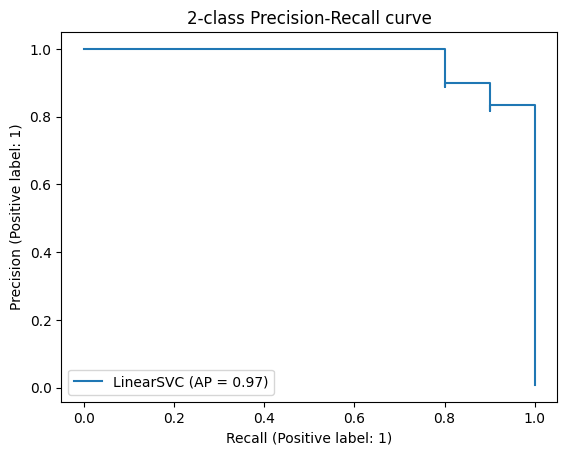

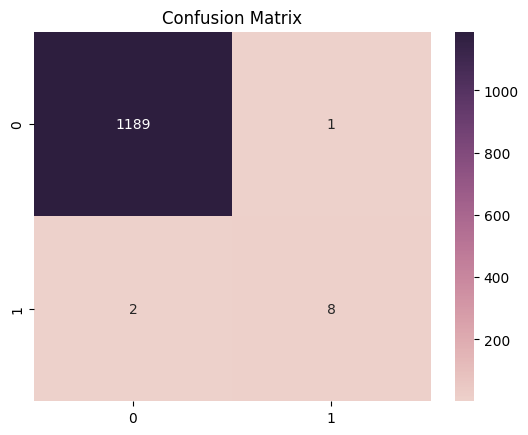

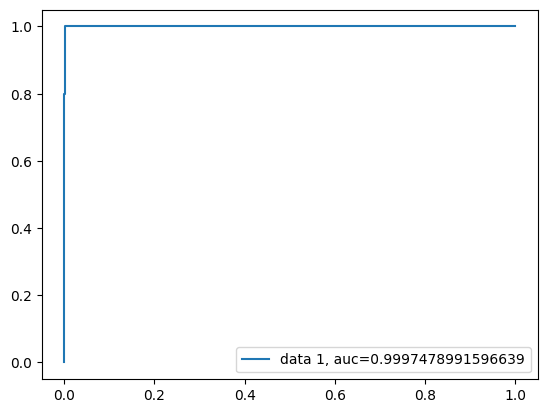

In [339]:
model = LGBMClassifier(num_leaves=15, min_data_in_leaf=310, max_depth=320, learning_rate=0.4551424885025239)

model.fit(X_smote, y_smote)
y_pred = model.predict(X_test)

print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
print(f"Recall score: {recall_score(y_test, y_pred)}")
print(f"Precision score: {precision_score(y_test, y_pred)}")
print(f"F1 score: {f1_score(y_test, y_pred)}")
print(f"Matthew's coeff: {matthews_corrcoef(y_test, y_pred)}")
y_pred_proba = model.predict_proba(X_test)[::, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
print(f"Precision-Recall: {pr_auc(recall, precision)}")

plt.figure()
display = PrecisionRecallDisplay.from_estimator(
    model, X_test, y_test, name="LinearSVC"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")
plt.show()

plt.figure()
cf_matrix = confusion_matrix(y_test, y_pred)
plt.title(f"Confusion Matrix")
sns.heatmap(
    cf_matrix, annot=True, fmt="g", cmap=sns.cubehelix_palette(as_cmap=True)
)
plt.show()

y_pred_proba = model.predict_proba(X_test)[::, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label="data 1, auc=" + str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
# No significant improvement evidenced on initial results so to proceed with Random Forest model as simpler model and, potentially, offers greater interpretability. 

In [35]:
### Model Analysis

In [35]:
## Random Forest feature importances

model = RandomForestClassifier(random_state=random_seed)
model.fit(X_smote, y_smote)

rf_feature_importances = dict(zip(X_smote.columns, model.feature_importances_))
rf_sorted_importances = sorted(rf_feature_importances.items(), key=lambda x: x[1], reverse=True)

for i, (feature, importance) in enumerate(rf_sorted_importances):
    print(f"{i + 1}. {feature}: {importance}")

1. oldbalanceDest: 0.19935109602052584
2. oldbalanceOrg: 0.16002302599387425
3. newbalanceOrig: 0.12340680428412502
4. newbalanceDest: 0.0920649961282002
5. amount: 0.06241591799366363
6. type_CASH_OUT: 0.0611950011365985
7. nameDestLabel_M: 0.05707947600749201
8. step: 0.046705893965823767
9. nameDestLabel_C: 0.045562785836688914
10. type_PAYMENT: 0.04435688941368686
11. type_TRANSFER: 0.04189934190164637
12. nameOrig: 0.020973721241492015
13. type_CASH_IN: 0.0209666343601655
14. nameDest: 0.01653124782204245
15. type_DEBIT: 0.007467167893974714


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


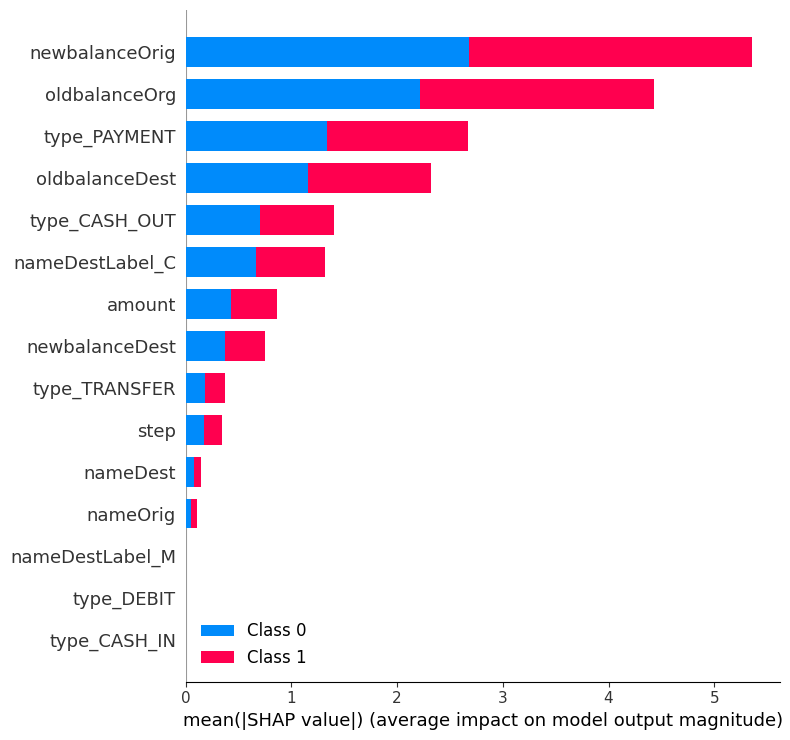

In [37]:
## SHAP Analysis

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_smote)

shap.summary_plot(shap_values, X_test)

In [38]:
# SHAP feature importances

shap_importances = np.abs(shap_values).mean(axis=0)
shap_feature_importances = {feature_name: importance for feature_name, importance in zip(X_smote.columns, shap_importances)}
    

In [39]:
# SHAP insight into randomly selected instances 

positive_indices = list(y_smote[y_smote == 1].index)
random_elements = random.sample(positive_indices, 10)

In [37]:
shap.initjs()

In [37]:
shap.force_plot(explainer.expected_value[1], shap_values[1][random_elements[0], :], X_smote.iloc[1, :])

In [38]:
shap.force_plot(explainer.expected_value[1], shap_values[1][random_elements[2], :], X_smote.iloc[1, :])

In [39]:
shap.force_plot(explainer.expected_value[1], shap_values[1][random_elements[5], :], X_smote.iloc[1, :])

In [ ]:
### Bayesian Modelling
# Leveraging a generalised linear model approach, to engineer probability estimates from feature importances via custom linear predictor and inverse logit link function.

In [44]:
## Using Random Forest feature importances for feature prior elicitation  

X_array = np.array(X_smote)

with pm.Model() as model:
    fraud_occurrence_prior = pm.Beta("fraud_occurrence_prior", alpha=1, beta=99) # Prior set to a conservative 1% fraud rate given observations of event rarity across full dataset  
    
    betas = []
    
    for feature_name, importance in rf_feature_importances.items():
        prior_std = abs(importance)
        feature_prior = pm.Normal(feature_name, mu=0, sigma=prior_std)
        betas.append(feature_prior)

    linear_predictor = pm.math.dot(X_array, betas)
    logit_probs = pm.math.invlogit(linear_predictor)
    
    fraud_occurrence_likelihood = pm.Bernoulli("fraud_occurrence_likelihood", p=logit_probs, observed=y_smote)    

    posterior = pm.sample(1000, tune=250, cores=1)

pm.summary(posterior)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [fraud_occurrence_prior, step, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest, type_CASH_IN, type_CASH_OUT, type_DEBIT, type_PAYMENT, type_TRANSFER, nameDestLabel_C, nameDestLabel_M]


Sampling 2 chains for 250 tune and 1_000 draw iterations (500 + 2_000 draws total) took 6922 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
step                    0.043  0.024   0.000    0.089      0.000    0.000   
amount                  0.007  0.035  -0.057    0.074      0.001    0.001   
nameOrig               -0.010  0.017  -0.041    0.023      0.000    0.000   
oldbalanceOrg           0.557  0.053   0.454    0.653      0.001    0.001   
newbalanceOrig         -0.461  0.056  -0.566   -0.361      0.001    0.001   
nameDest               -0.001  0.014  -0.029    0.025      0.000    0.000   
oldbalanceDest         -0.626  0.072  -0.764   -0.492      0.002    0.001   
newbalanceDest         -0.072  0.060  -0.191    0.034      0.001    0.001   
type_CASH_IN           -0.001  0.020  -0.040    0.037      0.000    0.001   
type_CASH_OUT           0.224  0.032   0.164    0.284      0.001    0.000   
type_DEBIT              0.001  0.007  -0.013    0.014      0.000    0.000   
type_PAYMENT           -0.155  0.041  -0.238   -0.082      0.001    0.001   
type_TRANSFER           0.103  0.028   0.052    0.157      0.001    0.000   
nameDestLabel_C         0.163  0.040   0.091    0.244      0.001    0.000   
nameDestLabel_M        -0.254  0.050  -0.349   -0.165      0.001    0.001   
fraud_occurrence_prior  0.010  0.010   0.000    0.028      0.000    0.000   

                        ess_bulk  ess_tail  r_hat  
step                      3074.0    1456.0    1.0  
amount                    2638.0    1128.0    1.0  
nameOrig                  4084.0    1489.0    1.0  
oldbalanceOrg             1463.0    1218.0    1.0  
newbalanceOrig            1434.0    1193.0    1.0  
nameDest                  2914.0    1398.0    1.0  
oldbalanceDest            1666.0    1498.0    1.0  
newbalanceDest            2274.0    1285.0    1.0  
type_CASH_IN              3415.0    1548.0    1.0  
type_CASH_OUT             2456.0    1752.0    1.0  
type_DEBIT                2961.0    1478.0    1.0  
type_PAYMENT              1947.0    1239.0    1.0  
type_TRANSFER             2376.0    1714.0    1.0  
nameDestLabel_C           3520.0    1552.0    1.0  
nameDestLabel_M           2952.0    1795.0    1.0  
fraud_occurrence_prior    2134.0     922.0    1.0

In [ ]:
# 'oldbalaneOrg' indicated to have the strongest positive impact on fraud occurrence with 'type_CASH_OUT', 'nameDestLabel_C' and 'type_TRANSFER' also significant.
# 94% credible interval expresses uncertainty in parameter values given observed data.

In [50]:
## Using SHAP feature importances for feature prior elicitation  

with pm.Model() as model:
    fraud_occurrence_prior = pm.Beta("fraud_occurrence_prior", alpha=1, beta=99) # Prior set to a conservative 1% fraud rate given observations of event rarity across full dataset  
    
    betas = []
    
    for feature_name, feature_importances in shap_feature_importances.items():
        prior_std = np.abs(feature_importances).mean()
        prior_distribution = pm.Normal(feature_name, mu=0, sigma=prior_std)
        betas.append(prior_distribution)

    linear_predictor = pm.math.dot(X_array, betas)
    logit_probs = pm.math.invlogit(linear_predictor)
    
    fraud_occurrence_likelihood = pm.Bernoulli("fraud_occurrence_likelihood", p=logit_probs, observed=y_smote)    

    posterior = pm.sample(1000, tune=250, cores=1)

pm.summary(posterior)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [fraud_occurrence_prior, step, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest, type_CASH_IN, type_CASH_OUT, type_DEBIT, type_PAYMENT, type_TRANSFER, nameDestLabel_C, nameDestLabel_M]


Sampling 2 chains for 250 tune and 1_000 draw iterations (500 + 2_000 draws total) took 3790 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
step                    0.047  0.017   0.016    0.079      0.000      0.0   
amount                  0.012  0.017  -0.017    0.046      0.000      0.0   
nameOrig               -0.009  0.016  -0.039    0.019      0.000      0.0   
oldbalanceOrg           0.087  0.018   0.053    0.120      0.000      0.0   
newbalanceOrig         -0.088  0.018  -0.123   -0.054      0.000      0.0   
nameDest               -0.007  0.016  -0.035    0.022      0.000      0.0   
oldbalanceDest         -0.125  0.022  -0.166   -0.087      0.000      0.0   
newbalanceDest         -0.039  0.019  -0.075   -0.004      0.000      0.0   
type_CASH_IN           -0.060  0.022  -0.102   -0.019      0.000      0.0   
type_CASH_OUT           0.141  0.019   0.107    0.180      0.000      0.0   
type_DEBIT             -0.020  0.017  -0.050    0.015      0.000      0.0   
type_PAYMENT           -0.056  0.017  -0.087   -0.024      0.000      0.0   
type_TRANSFER           0.094  0.016   0.063    0.125      0.000      0.0   
nameDestLabel_C         0.071  0.019   0.037    0.107      0.000      0.0   
nameDestLabel_M        -0.107  0.023  -0.149   -0.063      0.001      0.0   
fraud_occurrence_prior  0.010  0.010   0.000    0.027      0.000      0.0   

                        ess_bulk  ess_tail  r_hat  
step                      3286.0    1794.0    1.0  
amount                    2809.0    1266.0    1.0  
nameOrig                  2786.0    1794.0    1.0  
oldbalanceOrg             3041.0    1540.0    1.0  
newbalanceOrig            2084.0    1478.0    1.0  
nameDest                  2842.0    1885.0    1.0  
oldbalanceDest            2961.0    1107.0    1.0  
newbalanceDest            2531.0    1455.0    1.0  
type_CASH_IN              2320.0    1598.0    1.0  
type_CASH_OUT             2323.0    1462.0    1.0  
type_DEBIT                2557.0    1661.0    1.0  
type_PAYMENT              2427.0    1803.0    1.0  
type_TRANSFER             2554.0    1329.0    1.0  
nameDestLabel_C           2737.0    1618.0    1.0  
nameDestLabel_M           1985.0    1578.0    1.0  
fraud_occurrence_prior    1481.0     676.0    1.0

In [ ]:
# Most notably, 'oldbalanceOrg', 'type_CASH_OUT', 'nameDestLabel_C' and 'type_TRANSFER' continue to be the features most positively associated with the occurrence of fraud.
# The relative weightings for this model based on the SHAP analysis are different to the ones leveraging the Random Forest feature importances (type_CASH_OUT and type_TRANSFER are more significant)
# Differences to stem from workings of feature importance calculation: 
# Random forest focused internally on overall feature contribution via Gini impurities and information gain
# SHAP focused more on feature contribution to prediction for each instance with keener attention paid to relationships between features and target. 